# Volatility Forecasting & Economic Value  
## A Multi-Horizon Comparison of Rolling, EWMA and GARCH Models

---

## 1. Introduction

Volatility is a central object in quantitative finance.  
It drives:

- Risk management  
- Portfolio allocation  
- Derivatives pricing  
- Volatility targeting strategies  

Financial returns exhibit well-known stylized facts:

- Volatility clustering  
- Heavy tails  
- Persistence  
- Low autocorrelation of returns  
- High autocorrelation of squared returns  

The objective of this project is to:

1. Build a clean volatility forecasting pipeline
2. Compare multiple models:
   - Rolling volatility
   - EWMA (RiskMetrics)
   - GARCH(1,1)
3. Evaluate forecasts statistically using:
   - MAE
   - MSE
   - QLIKE
4. Evaluate economic value via a volatility targeting strategy
5. Analyze dynamics through interactive 3D volatility surfaces

We work in a **multi-horizon setting (1, 5, 10 days)** and annualize all volatility measures for consistency.

The goal is not only to identify the best statistical model, but to understand:

> Does better volatility forecasting translate into better portfolio performance?


In [12]:
# --- Core imports ---
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.io as pio

pio.renderers.default = "notebook_connected"

# --- Make src/ importable ---
ROOT = Path.cwd().resolve()
PROJECT_ROOT = ROOT.parent if ROOT.name == "notebooks" else ROOT
SRC_PATH = PROJECT_ROOT / "src"

if str(SRC_PATH) not in sys.path:
    sys.path.insert(0, str(SRC_PATH))


In [13]:
from config import cfg
from utils import ensure_dir

# Ensure required folders exist
ensure_dir(cfg.data_raw_dir)
ensure_dir(cfg.data_processed_dir)
ensure_dir(cfg.reports_figures_dir)
ensure_dir(cfg.reports_tables_dir)

cfg


ProjectConfig(project_root=WindowsPath('C:/Users/mathi/Desktop/GIT/volatility-forecasting'), data_raw_dir=WindowsPath('C:/Users/mathi/Desktop/GIT/volatility-forecasting/data/raw'), data_processed_dir=WindowsPath('C:/Users/mathi/Desktop/GIT/volatility-forecasting/data/processed'), reports_figures_dir=WindowsPath('C:/Users/mathi/Desktop/GIT/volatility-forecasting/reports/figures'), reports_tables_dir=WindowsPath('C:/Users/mathi/Desktop/GIT/volatility-forecasting/reports/tables'), ticker='SPY', start='2005-01-01', end='2025-01-01', trading_days=252, random_seed=42, horizons=(1, 5, 10), train_window=1000, refit_every=1, roll_windows=(20, 60), ewma_lambda=0.94, vol_target_annual=0.15, w_min=0.0, w_max=2.0)

---

## 2. Data & Stylized Facts

We use daily data for the ETF:

$$
\text{Ticker: } SPY
$$

over the period:

$$
2005 - 2025
$$

Prices are downloaded via `yfinance`, and we construct:

- Log returns:
$$
r_t = \log \left(\frac{P_t}{P_{t-1}}\right)
$$

- Rolling volatility baselines:
$$
\hat{\sigma}^{\text{roll}}_t = \sqrt{252} \cdot \text{Std}(r_{t-w+1:t})
$$

- Realized volatility targets for horizon \( h \):
$$
\sigma^{\text{real}}_{t,h} = 
\sqrt{ \sum_{i=0}^{h-1} r_{t-i}^2 }
$$

Annualized as:

$$
\sigma^{\text{real,ann}}_{t,h}
=
\sigma^{\text{real}}_{t,h}
\sqrt{\frac{252}{h}}
$$

---

### Stylized Facts to Verify

We verify standard empirical properties:

1. Returns have low autocorrelation.
2. Squared returns exhibit strong autocorrelation.
3. Volatility is time-varying and clustered.
4. Return distribution exhibits heavy tails.

The following plots confirm these stylized facts.


In [14]:
from data import build_dataset

df, r = build_dataset(cfg, save=True)

print("Dataset shape:", df.shape)
df.head()


Dataset shape: (4973, 7)


adj_close         r  roll_vol_20d  roll_vol_60d  realized_vol_1d  \
Date                                                                           
2005-03-31  80.332947 -0.001863      0.108149      0.104171         0.029575   
2005-04-01  79.971992 -0.004503      0.108615      0.101517         0.071489   
2005-04-04  80.108192  0.001702      0.096607      0.100587         0.027013   
2005-04-05  80.489594  0.004750      0.099170      0.100520         0.075400   
2005-04-06  80.768776  0.003463      0.100500      0.100721         0.054966   

            realized_vol_5d  realized_vol_10d  
Date                                           
2005-03-31         0.112069          0.097979  
2005-04-01         0.116230          0.100045  
2005-04-04         0.116402          0.099293  
2005-04-05         0.111550          0.100395  
2005-04-06         0.055536          0.088050

In [15]:
from plots import (
    plot_price,
    plot_returns,
    plot_rolling_vol,
    plot_hist_returns,
    plot_acf_returns,
    plot_acf_squared_returns,
    plot_realized_targets,
)

plot_price(cfg, df)
plot_returns(cfg, df)
plot_rolling_vol(cfg, df)
plot_hist_returns(cfg, df)
plot_acf_returns(cfg, df)
plot_acf_squared_returns(cfg, df)
plot_realized_targets(cfg, df)



WindowsPath('C:/Users/mathi/Desktop/GIT/volatility-forecasting/reports/figures/07_realized_vol_targets.png')


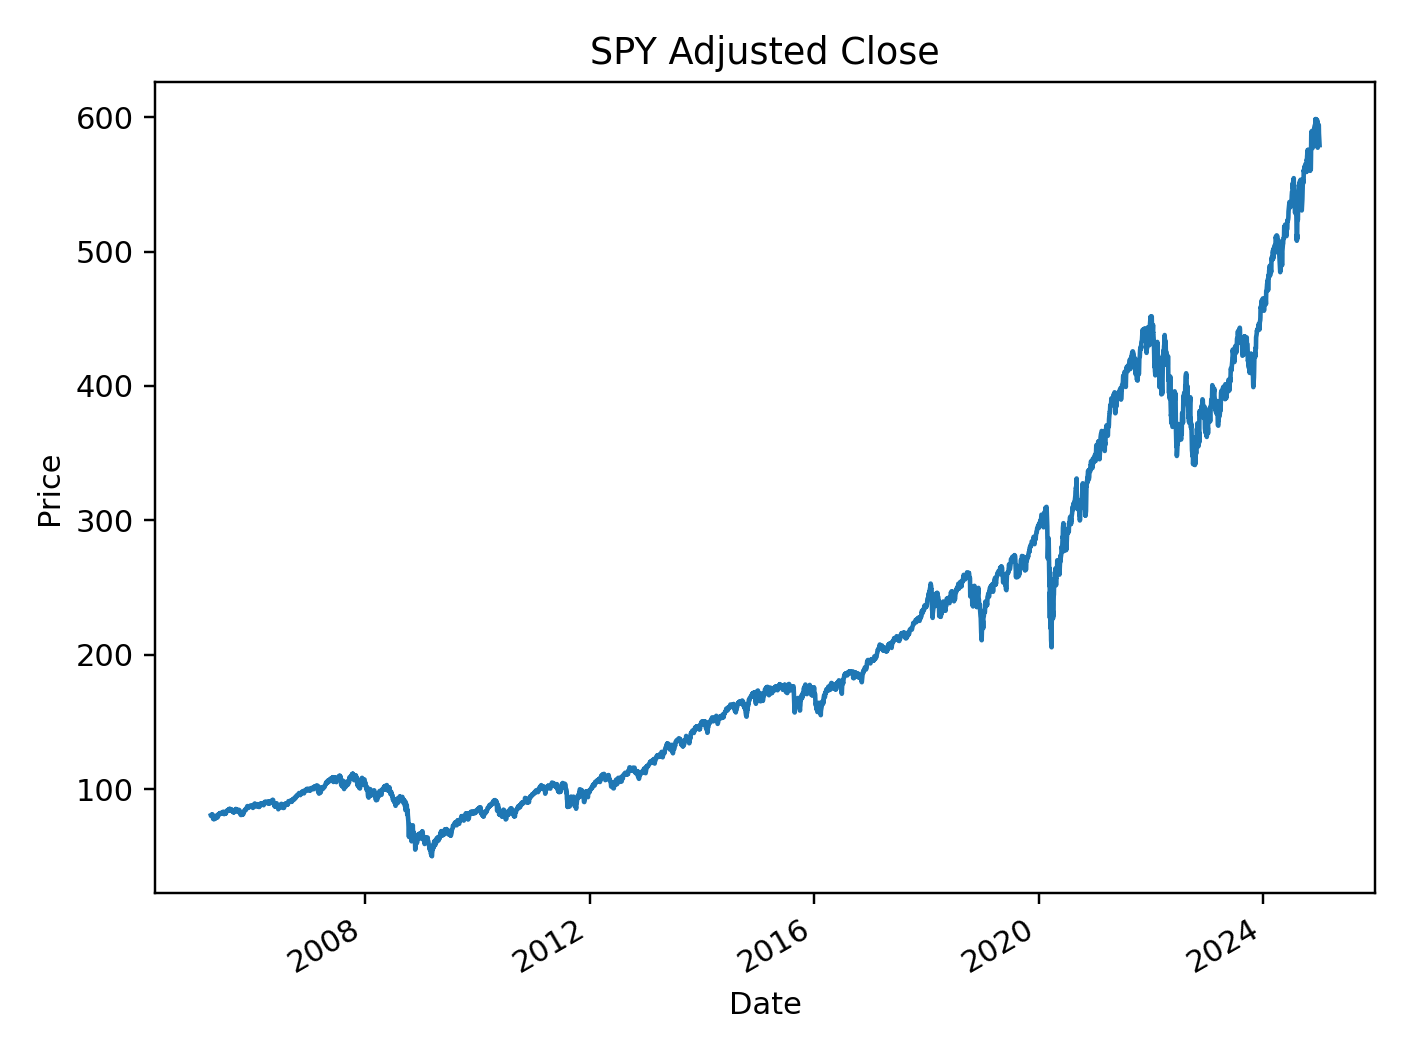
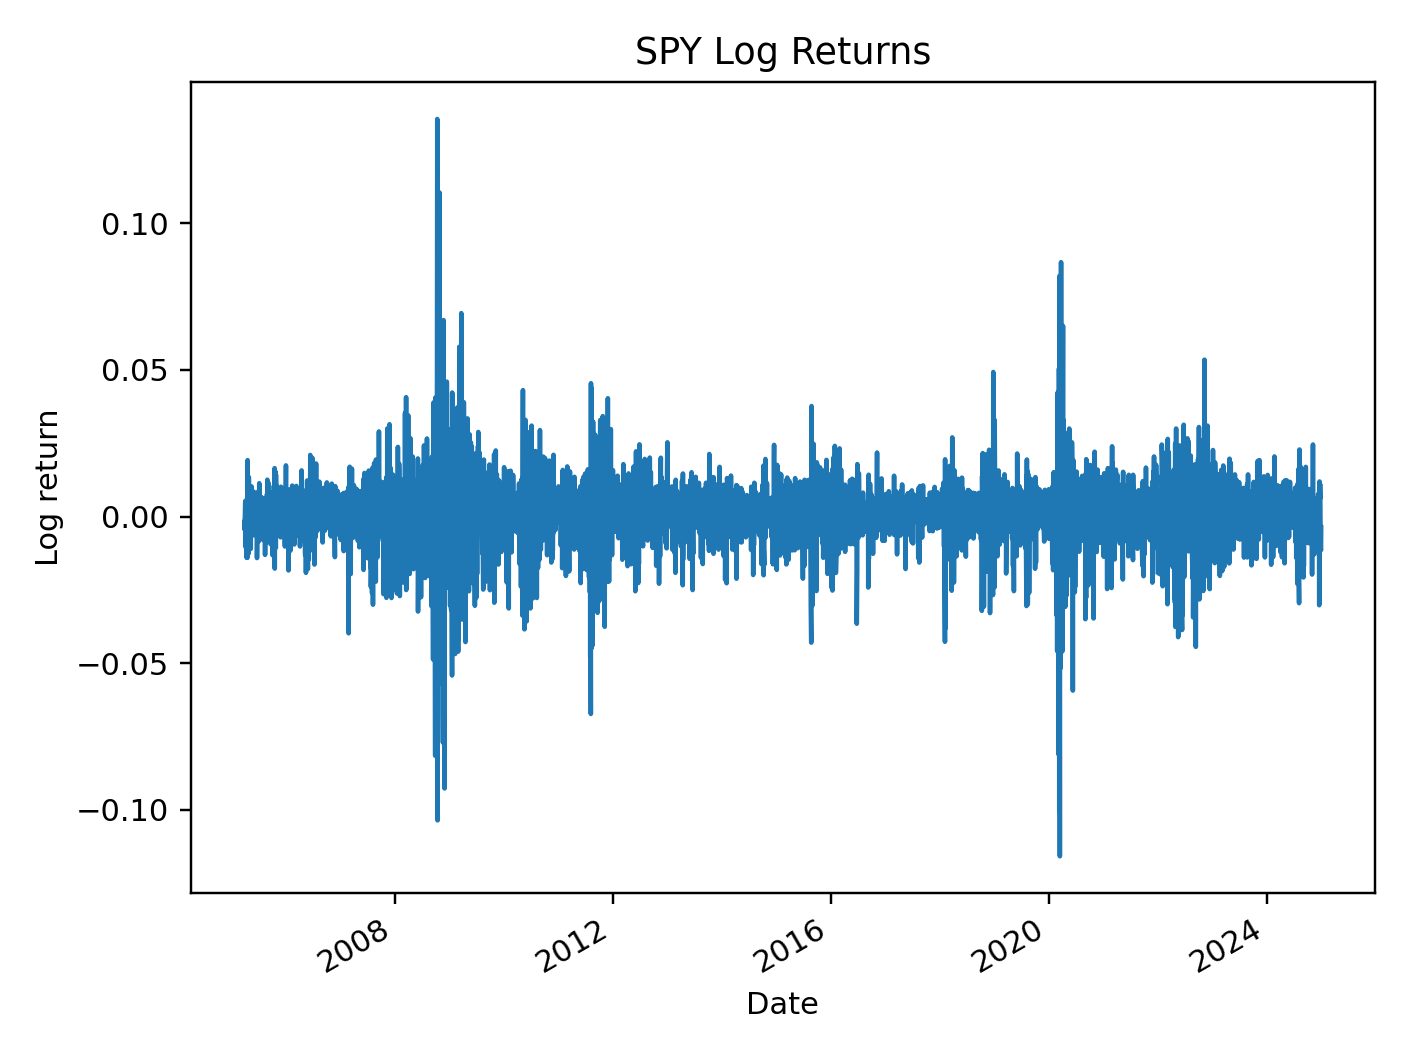
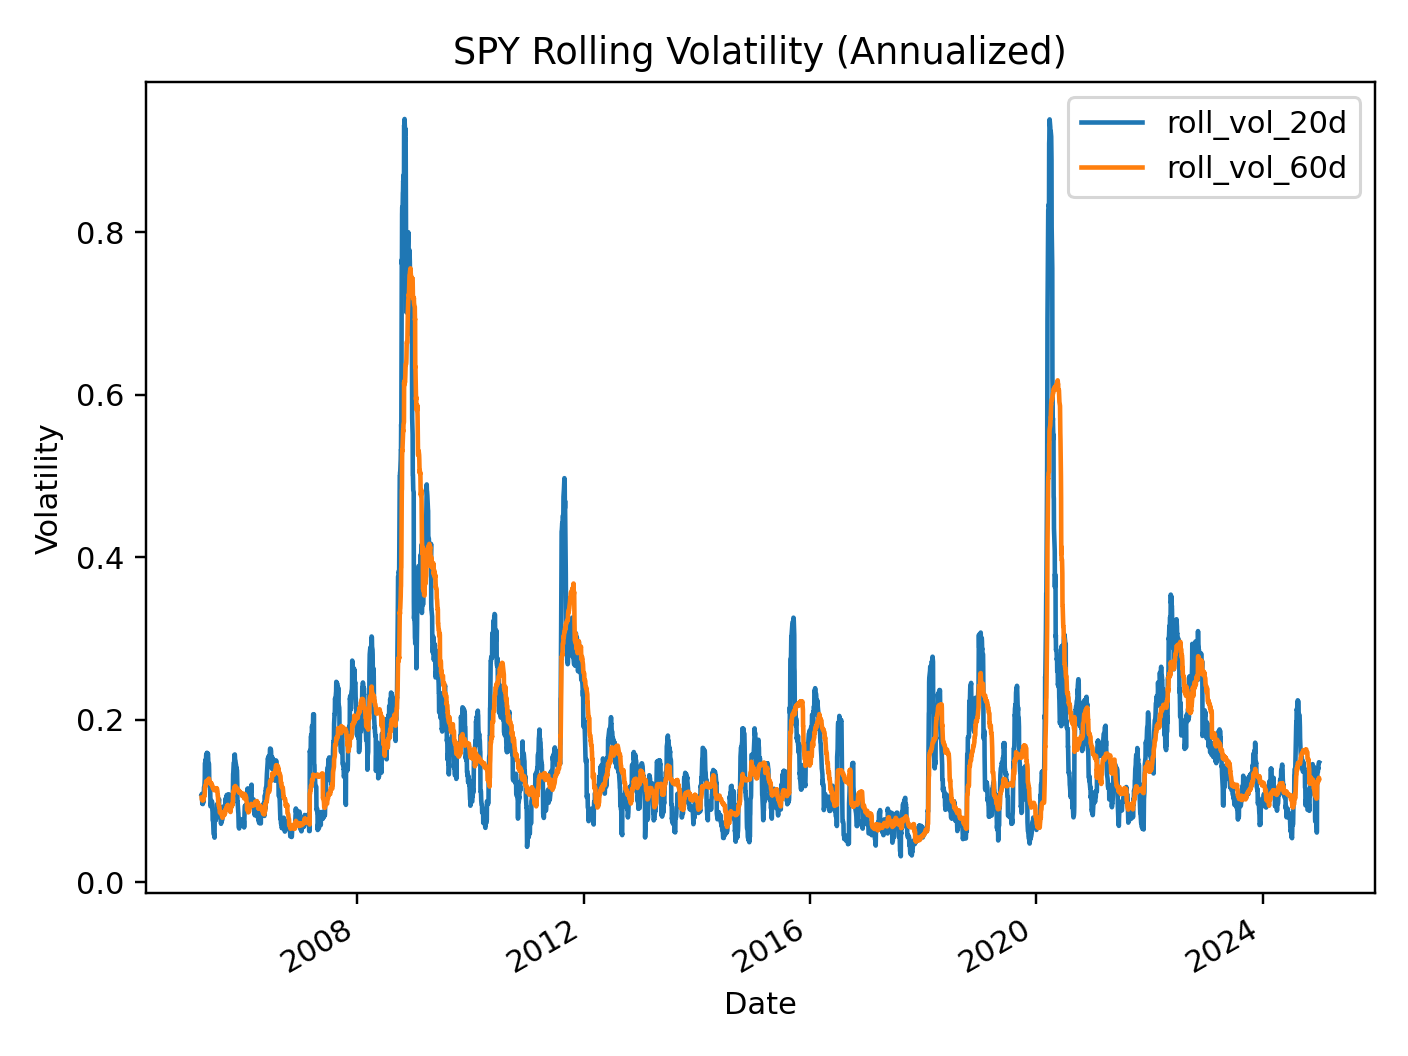
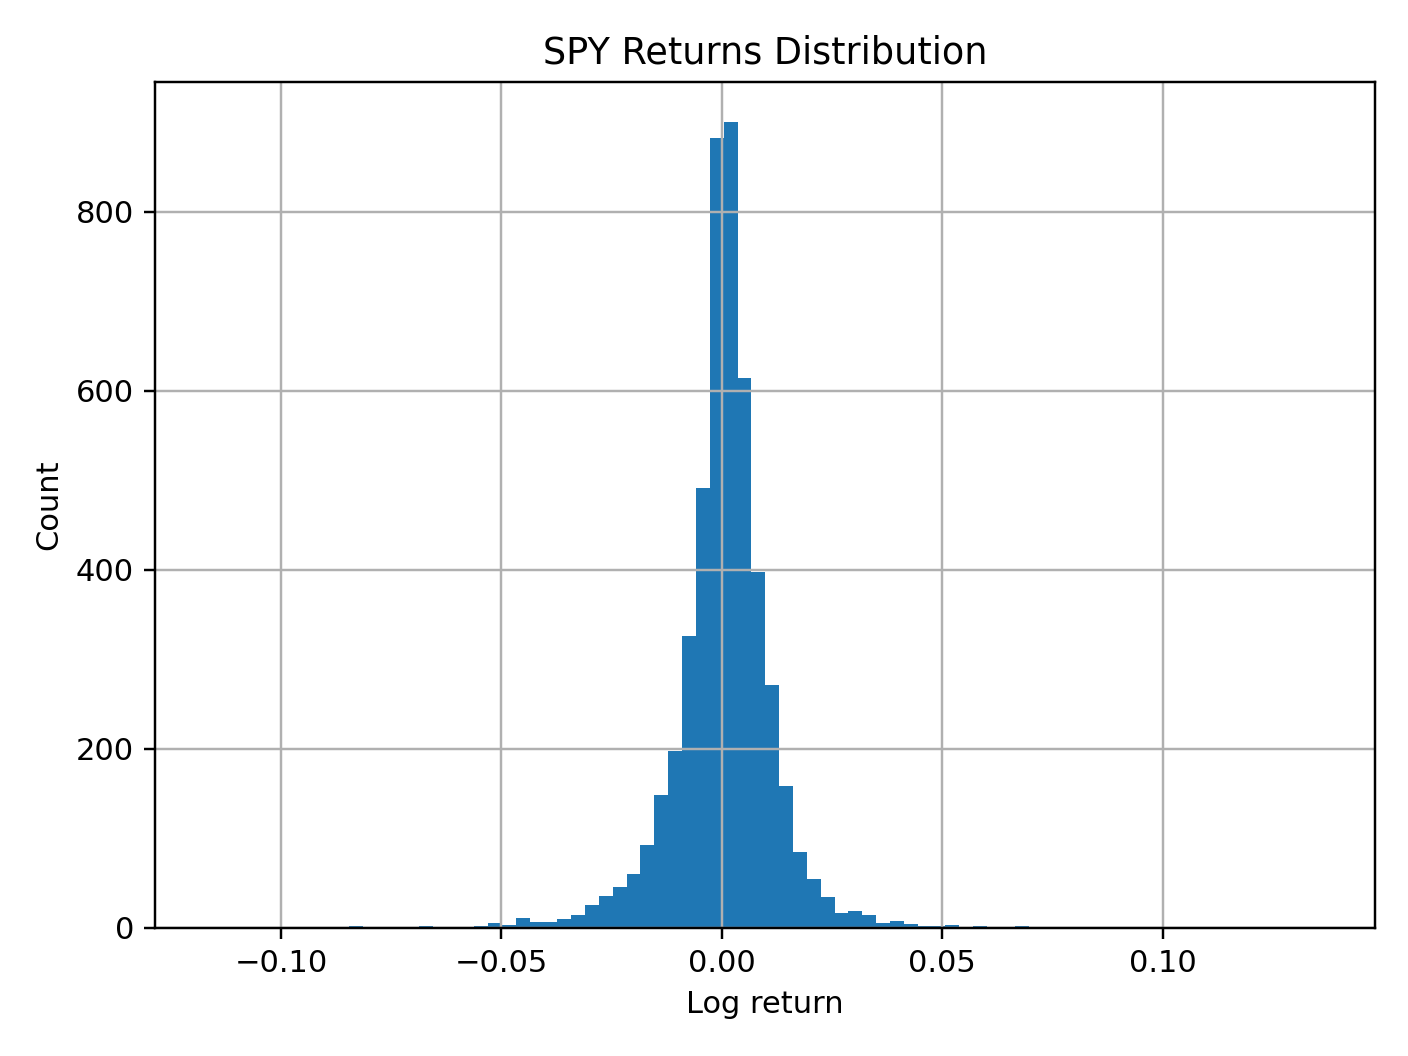
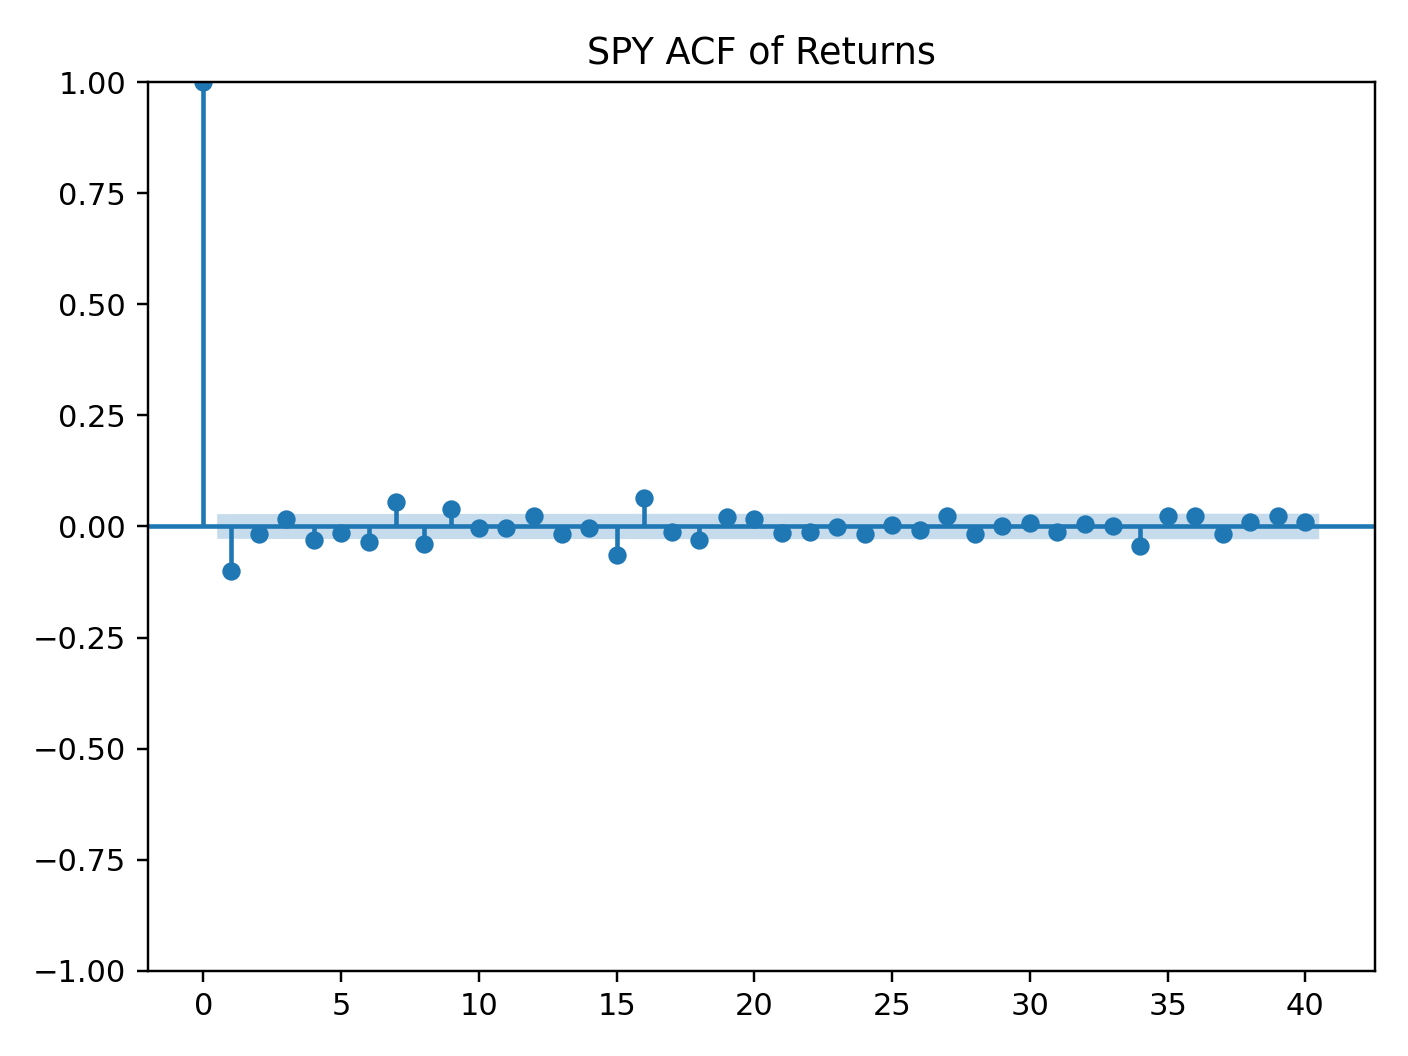
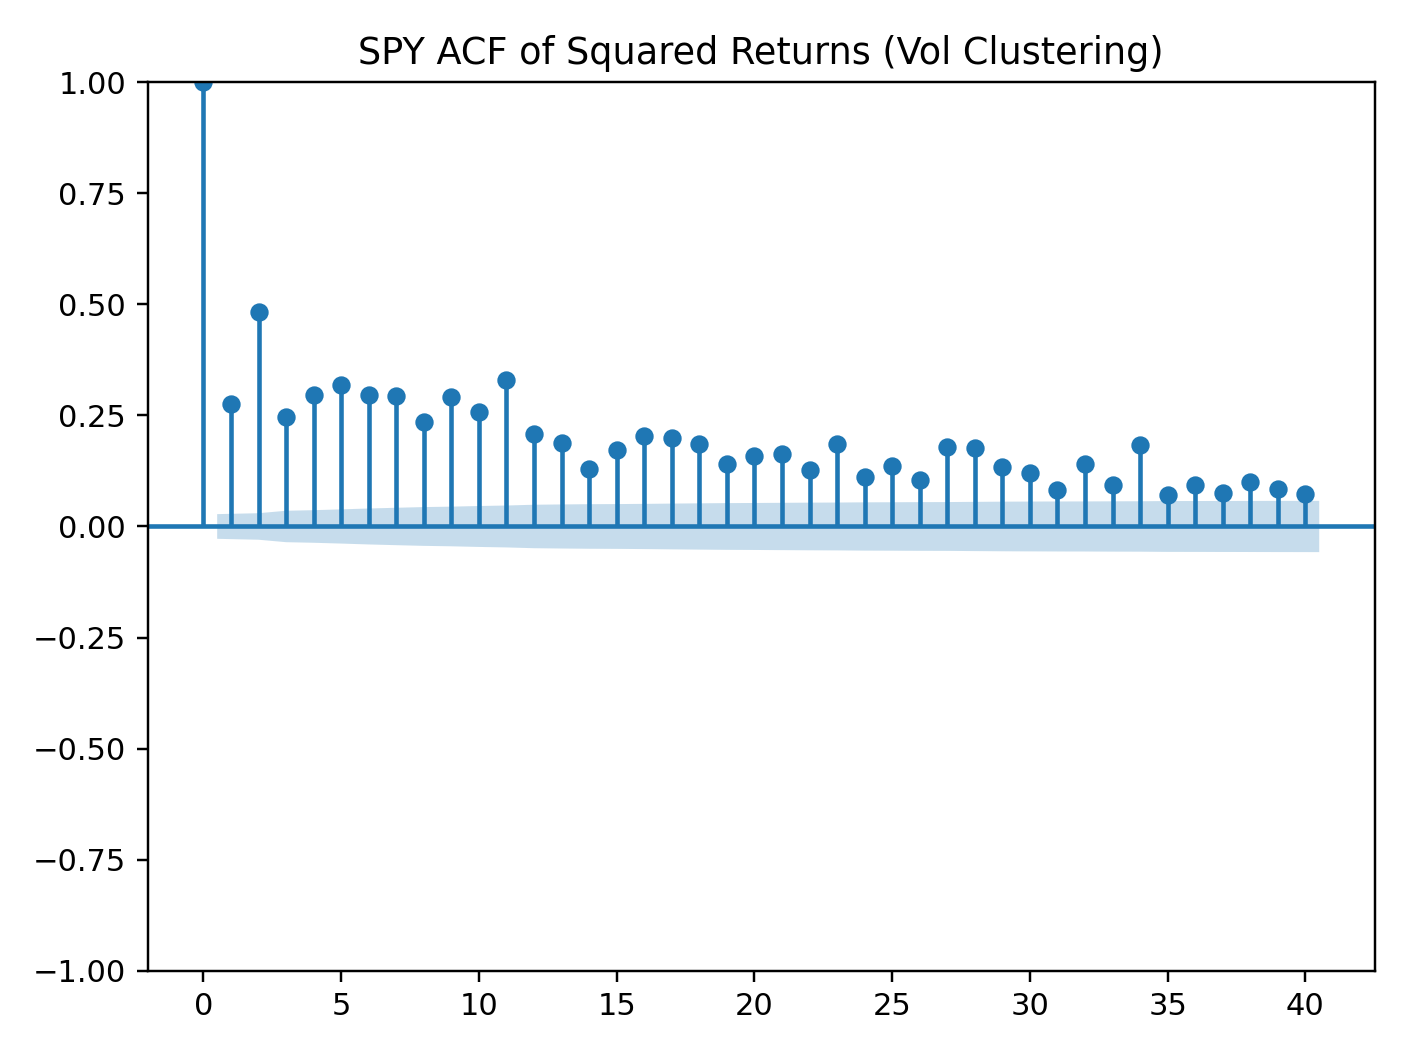
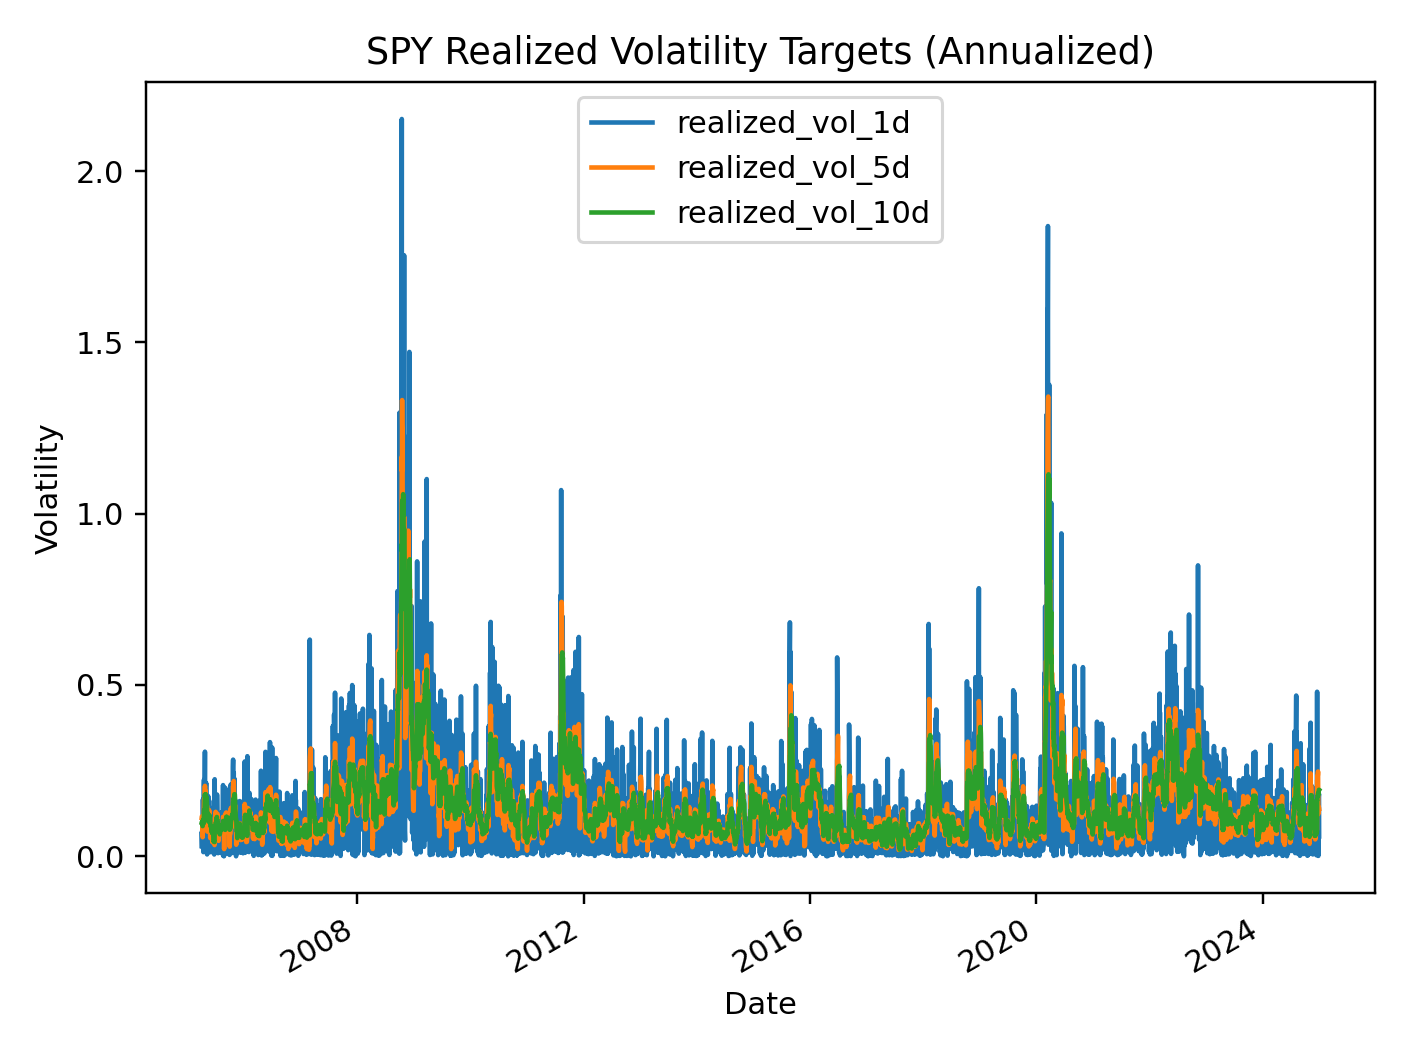

In [ ]:
from IPython.display import display, HTML
from pathlib import Path
import base64

root = Path.cwd()
if root.name == "notebooks":
    root = root.parent

fig_path = root / "reports" / "figures"

section_imgs = [
    "01_price.png",
    "02_returns.png",
    "03_rolling_vol.png",
    "04_returns_hist.png",
    "05_acf_returns.png",
    "06_acf_sq_returns.png",
    "07_realized_vol_targets.png",
]

def img_to_base64(path):
    with open(path, "rb") as f:
        return base64.b64encode(f.read()).decode()

html = "<div style='display:grid; grid-template-columns: repeat(3, 1fr); gap:15px;'>"

for img in section_imgs:
    img_path = fig_path / img
    img_base64 = img_to_base64(img_path)
    html += f"""
        <div>
            <img src="data:image/png;base64,{img_base64}" 
                 style="width:100%; border-radius:6px;">
        </div>
    """

html += "</div>"

display(HTML(html))




---

## 3. Volatility Forecasting Models

We compare three classes of volatility models.

All forecasts are expressed in **annualized volatility** for consistency.

---

### 3.1 Rolling Volatility (Baseline)

The simplest estimator is the rolling standard deviation:

$$
\hat{\sigma}^{\text{roll}}_t
=
\sqrt{252} \cdot \text{Std}(r_{t-w+1:t})
$$
This method assumes:

- Constant volatility within the window
- Equal weighting of past observations

We use window sizes:

$$
w \in \{20, 60\}
$$

---

### 3.2 EWMA (RiskMetrics)

The EWMA model updates variance recursively:

$$
\sigma_t^2
=
\lambda \sigma_{t-1}^2
+
(1-\lambda) r_{t-1}^2
$$

where:

$
\lambda \in (0,1)
$

Properties:

- Exponentially decaying weights
- High persistence
- No explicit mean reversion
- Widely used in risk management

The 1-day ahead forecast is:

$$
\hat{\sigma}_{t}^{\text{EWMA}}
=
\sqrt{\sigma_t^2}
$$

---

### 3.3 GARCH(1,1)

The GARCH(1,1) model generalizes EWMA:

$$
\sigma_t^2
=
\omega
+
\alpha r_{t-1}^2
+
\beta \sigma_{t-1}^2
$$

Properties:

- Captures volatility clustering
- Allows mean reversion
- More flexible than EWMA
- Estimated via maximum likelihood

We implement:

- Zero-mean specification
- Normal innovations
- Rolling window estimation
- Walk-forward forecasting

---

### Multi-Horizon Extension

Forecasts are constructed for:

$$
h \in \{1, 5, 10\}
$$

We evaluate models at multiple horizons to analyze persistence and term structure of volatility.


In [17]:
from models import build_forecast_panel

forecast_panel = build_forecast_panel(df, cfg, include_baselines=True)

print("Forecast panel shape:", forecast_panel.shape)
print("Forecast columns:", list(forecast_panel.columns))
forecast_panel.head()


Forecast panel shape: (3973, 12)
Forecast columns: ['ewma_h=1', 'garch_h=1', 'roll20_h=1', 'roll60_h=1', 'ewma_h=5', 'garch_h=5', 'roll20_h=5', 'roll60_h=5', 'ewma_h=10', 'garch_h=10', 'roll20_h=10', 'roll60_h=10']


ewma_h=1  garch_h=1  roll20_h=1  roll60_h=1  ewma_h=5  garch_h=5  \
Date                                                                           
2009-03-20  0.409772   0.394729    0.448068    0.377276  0.421205   0.394729   
2009-03-23  0.406009   0.389299    0.489742    0.404143  0.415814   0.392014   
2009-03-24  0.477186   0.494173    0.482109    0.405818  0.427262   0.426067   
2009-03-25  0.469075   0.479780    0.481351    0.406275  0.436345   0.439495   
2009-03-26  0.456611   0.459691    0.479053    0.408563  0.443731   0.443534   

            roll20_h=5  roll60_h=5  ewma_h=10  garch_h=10  roll20_h=10  \
Date                                                                     
2009-03-20    0.442238    0.373833   0.423202    0.394729     0.430512   
2009-03-23    0.451363    0.381161   0.423192    0.392014     0.443697   
2009-03-24    0.460873    0.387637   0.431271    0.426067     0.448464   
2009-03-25    0.468759    0.393858   0.433636    0.439495     0.455180   
2009-03-26    0.476065    0.400415   0.436039    0.443534     0.458812   

            roll60_h=10  
Date                     
2009-03-20     0.373151  
2009-03-23     0.378281  
2009-03-24     0.381397  
2009-03-25     0.384758  
2009-03-26     0.387497

---

## 4. Forecast Evaluation

We evaluate forecasting accuracy by comparing predicted volatility to realized volatility.

Let:

$$
\hat{\sigma}_{t,h}
$$

be the forecast volatility and

$$
\sigma^{\text{real}}_{t,h}
$$

the realized volatility over horizon $h$.

---

### 4.1 Mean Absolute Error (MAE)

$$
\text{MAE}
=
\mathbb{E}
\left[
\left|
\sigma^{\text{real}}_{t,h}
-
\hat{\sigma}_{t,h}
\right|
\right]
$$

Measures the average absolute deviation between forecast and realized volatility.

---

### 4.2 Mean Squared Error (MSE)

$$
\text{MSE}
=
\mathbb{E}
\left[
\left(
\sigma^{\text{real}}_{t,h}
-
\hat{\sigma}_{t,h}
\right)^2
\right]
$$

Penalizes large errors more heavily.

---

### 4.3 QLIKE (Quasi-Likelihood Loss)

QLIKE is widely used in volatility forecasting literature:

$$
\text{QLIKE}
=
\mathbb{E}
\left[
\log\left(\left(\hat{\sigma}_{t,h}\right)^2\right)
+
\frac{\left(\sigma^{\text{real}}_{t,h}\right)^2}
{\left(\hat{\sigma}_{t,h}\right)^2}
\right]
$$


Properties:

- Robust to noise in realized volatility
- Proper scoring rule under Gaussian assumptions
- Standard benchmark in academic research

Models are ranked primarily by QLIKE.


In [18]:
from metrics import (
    evaluate_forecasts,
    save_metrics_table,
    save_metrics_markdown,
)

# Compute metrics
metrics_df = evaluate_forecasts(df, forecast_panel, cfg)

print("Metrics table:")
metrics_df

# Save results
save_metrics_table(cfg, metrics_df, filename="metrics_table.csv")
save_metrics_markdown(cfg, metrics_df, filename="metrics_table.md")

# Best model per horizon (by QLIKE)
best = (
    metrics_df
    .sort_values(["horizon_days", "QLIKE"])
    .groupby("horizon_days", as_index=False)
    .first()
)

print("Best model per horizon (by QLIKE):")
best


Metrics table:
Best model per horizon (by QLIKE):


horizon_days   model       MAE      RMSE       MSE     QLIKE  n_obs
0             1  roll20  0.085833  0.117535  0.013814 -3.019828   3973
1             5   garch  0.041230  0.056796  0.003226 -3.010602   3973
2            10   garch  0.030895  0.042553  0.001811 -2.999493   3973

---

## 5. Volatility Term Structure & 3D Surfaces

To better understand volatility dynamics across time and forecast horizon,
we construct interactive 3D volatility surfaces.

For each date $t$ and horizon $h$:

$$
\sigma_{t,h}
$$

we visualize volatility as a function of:

- Time (x-axis)
- Horizon (y-axis)
- Annualized volatility (z-axis)

---

### Why 3D Surfaces?

Volatility is not constant across horizons.

The surface reveals:

- Volatility clustering over time
- Term structure shape (short vs long horizon)
- Regime shifts (crisis periods)
- Persistence structure

---

### Realized Volatility Surface

We first visualize:

$$
\sigma^{\text{real}}_{t,h}
$$

This represents the actual observed volatility term structure.

---

### Forecast Surfaces

We then compare forecasted surfaces:

$$
\hat{\sigma}^{\text{EWMA}}_{t,h}
$$

$$
\hat{\sigma}^{\text{GARCH}}_{t,h}
$$

Comparing surfaces allows us to visually assess:

- Under/overestimation
- Smoothing behavior
- Reaction speed to shocks
- Horizon dependence

---

### Error Surfaces

We also analyze forecast errors:

$$
\hat{\sigma}_{t,h}
-
\sigma^{\text{real}}_{t,h}
$$

This provides insight into:

- Systematic bias
- Regime-dependent forecasting errors
- Horizon-dependent mispricing of risk


In [19]:
from plots import plot_vol_surface_3d_research, plot_error_surface_3d

# --- Realized surface (h=1,h=5,h=10)
realized_surface = df[[f"realized_vol_{h}d" for h in cfg.horizons]].copy()
realized_surface.columns = [f"h={h}" for h in cfg.horizons]

# --- EWMA forecast surface
ewma_surface = forecast_panel[[f"ewma_h={h}" for h in cfg.horizons]].copy()
ewma_surface.columns = [f"h={h}" for h in cfg.horizons]

# --- GARCH forecast surface
garch_surface = forecast_panel[[f"garch_h={h}" for h in cfg.horizons]].copy()
garch_surface.columns = [f"h={h}" for h in cfg.horizons]

# Forecast surfaces
plot_vol_surface_3d_research(
    cfg,
    realized_surface,
    title="Realized Volatility Surface",
    filename_html="20_surface_realized.html",
    smooth_window=5,
)

plot_vol_surface_3d_research(
    cfg,
    ewma_surface,
    title="EWMA Forecast Volatility Surface",
    filename_html="21_surface_ewma.html",
    smooth_window=5,
)

plot_vol_surface_3d_research(
    cfg,
    garch_surface,
    title="GARCH Forecast Volatility Surface",
    filename_html="22_surface_garch.html",
    smooth_window=5,
)

# Error surfaces: (forecast - realized)
plot_error_surface_3d(
    cfg,
    realized_surface,
    ewma_surface,
    title="EWMA Error Surface (Forecast - Realized)",
    filename_html="23_surface_error_ewma.html",
    smooth_window=5,
)

plot_error_surface_3d(
    cfg,
    realized_surface,
    garch_surface,
    title="GARCH Error Surface (Forecast - Realized)",
    filename_html="24_surface_error_garch.html",
    smooth_window=5,
)


WindowsPath('C:/Users/mathi/Desktop/GIT/volatility-forecasting/reports/figures/24_surface_error_garch.html')


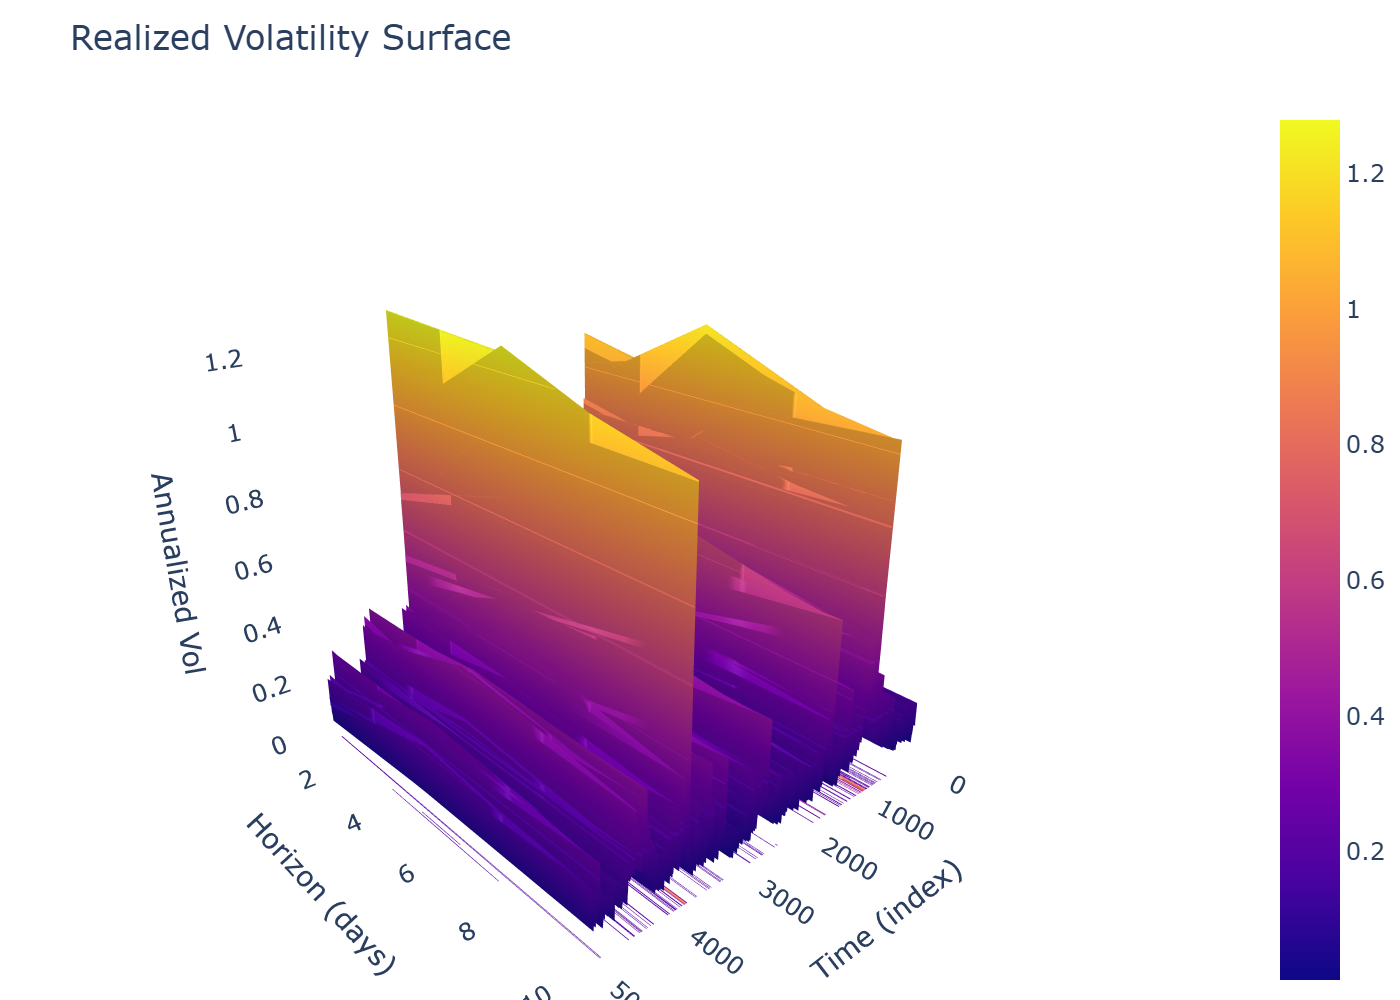
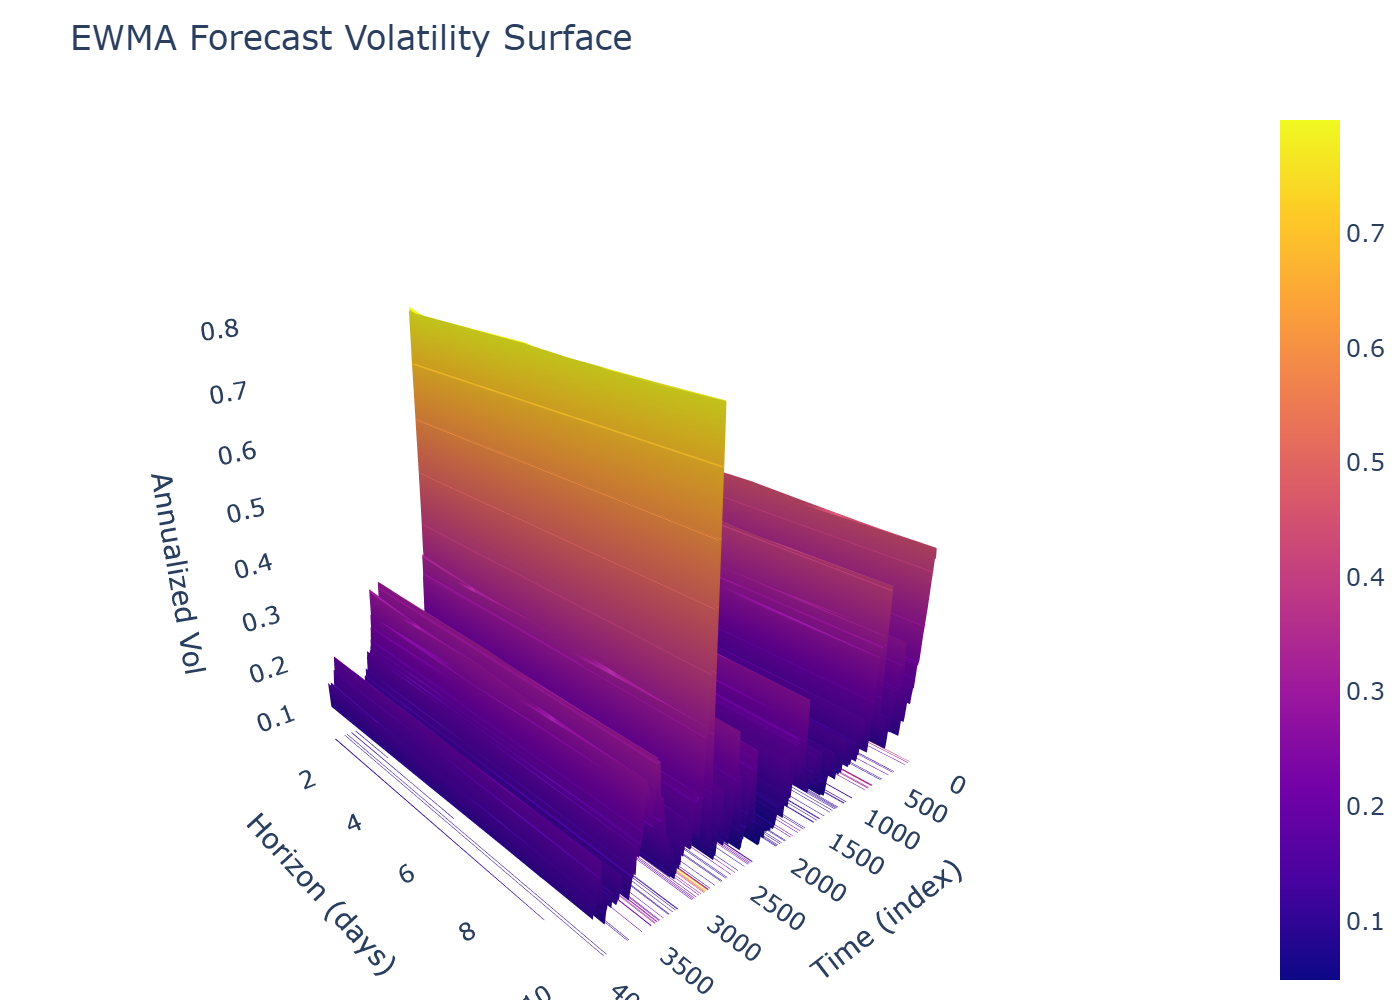
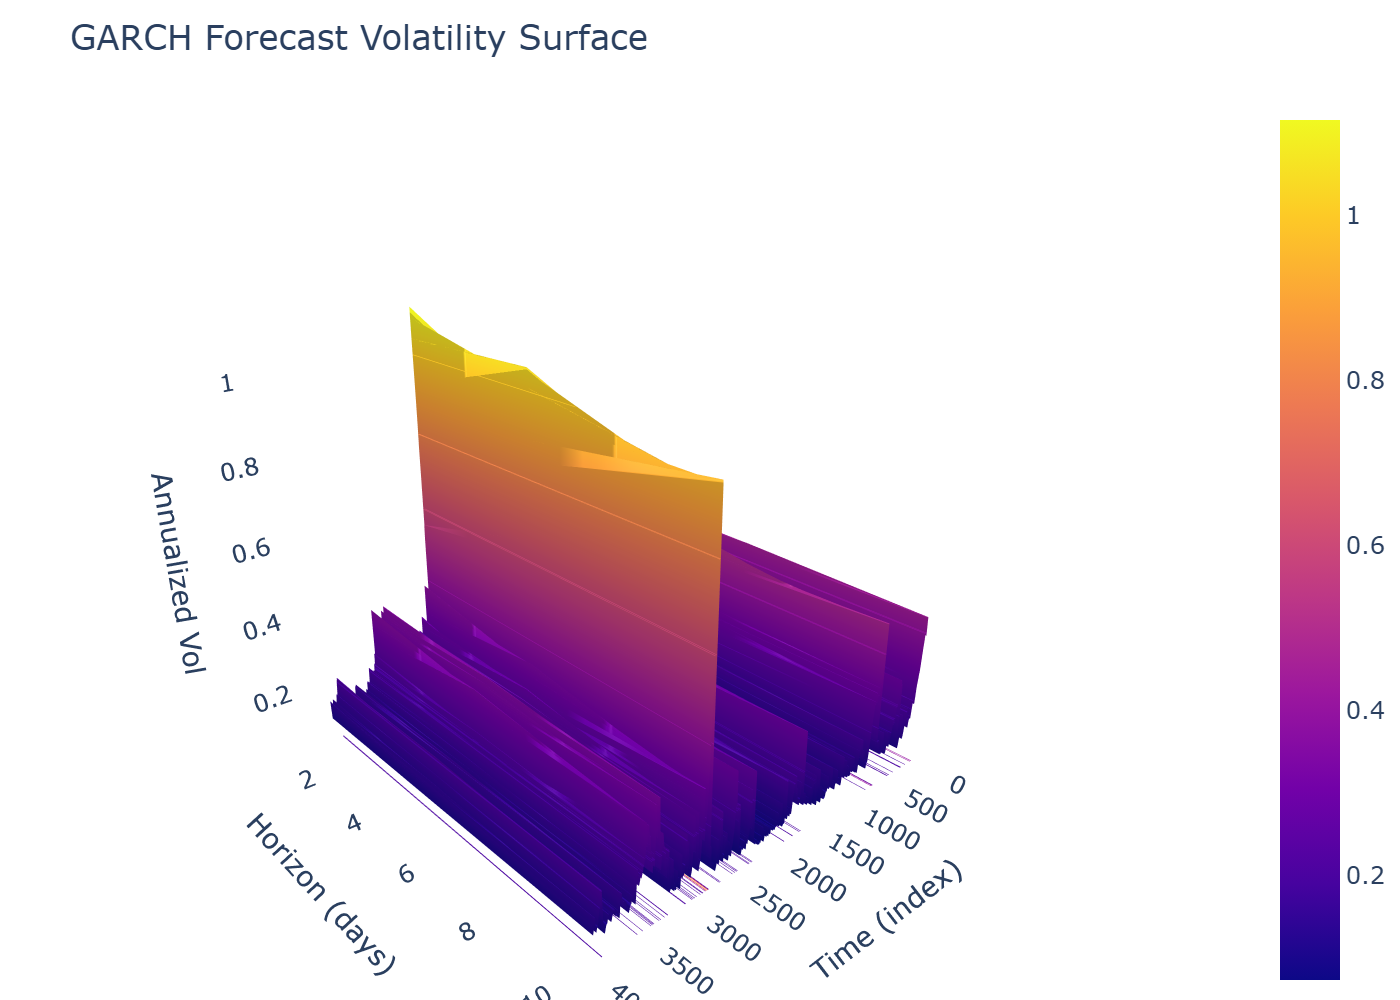
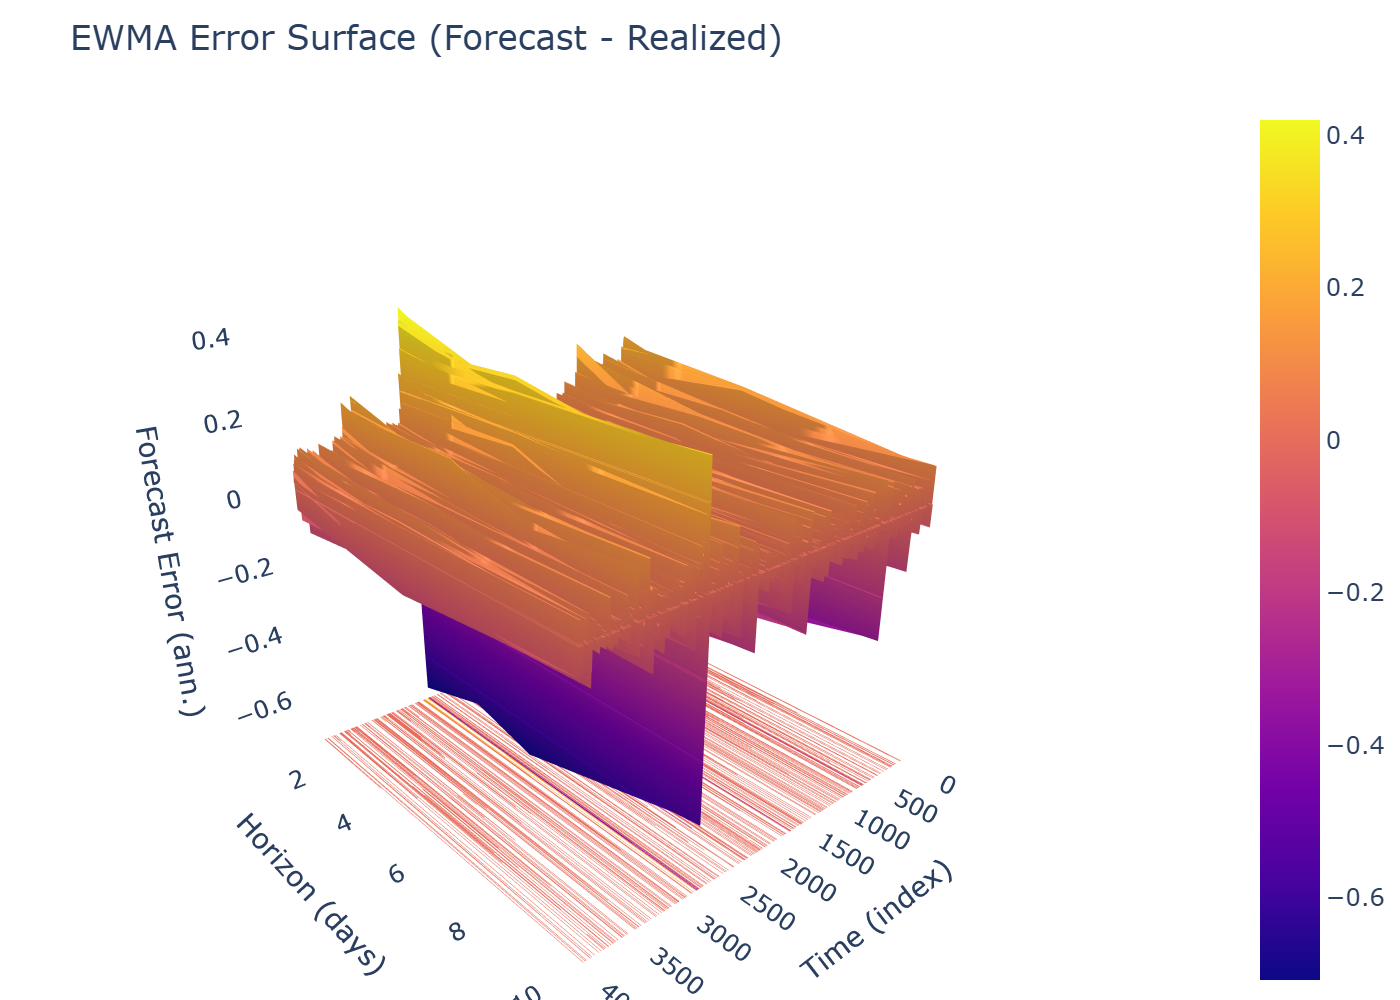
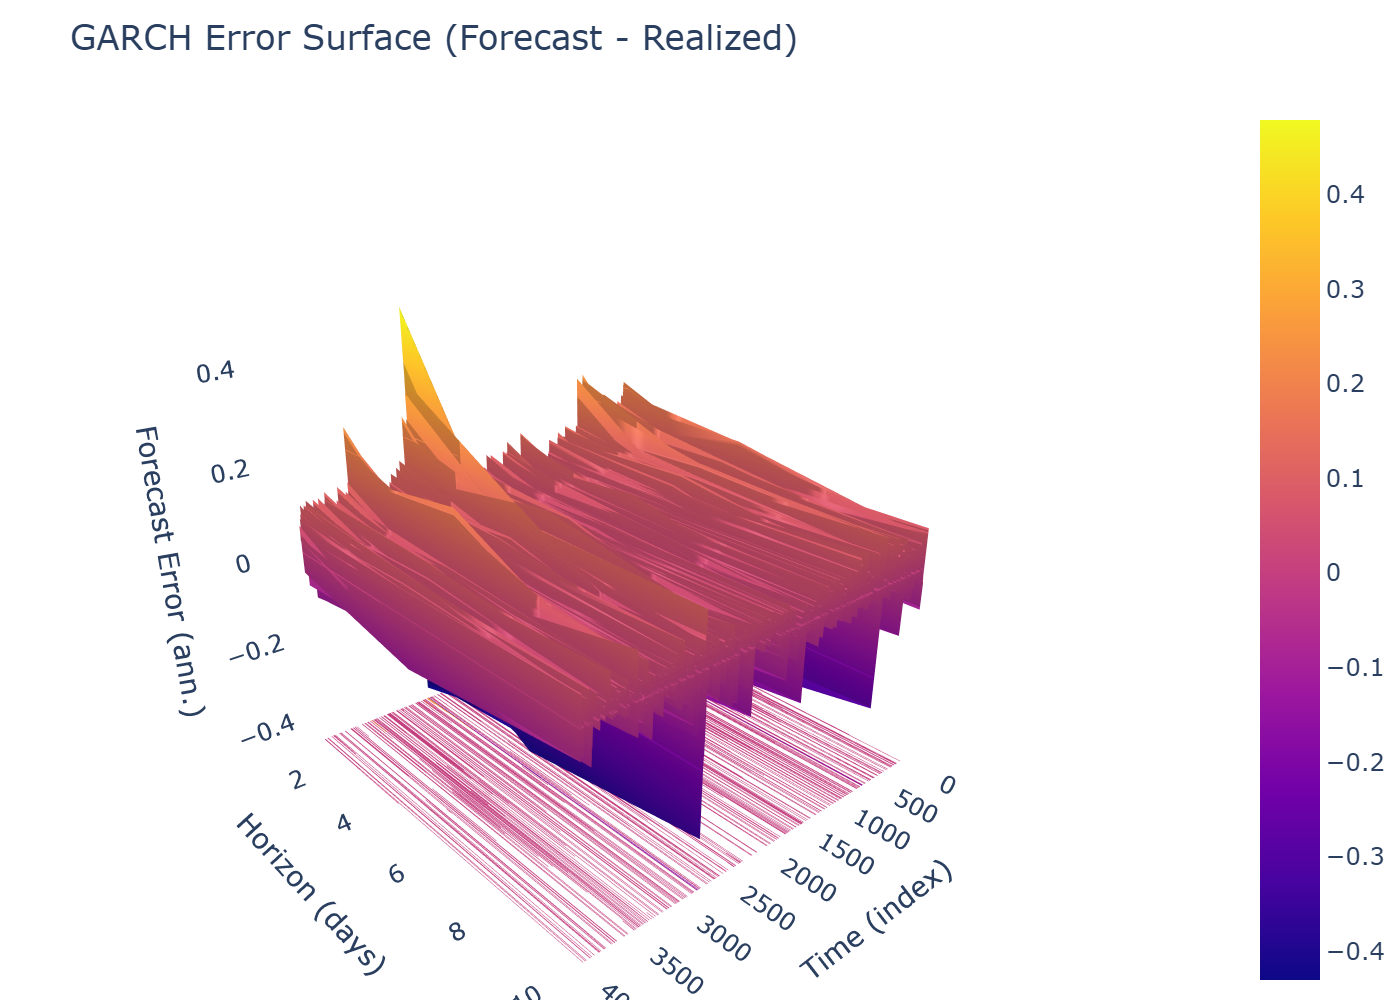

In [ ]:
from IPython.display import display, HTML
from pathlib import Path
import base64


root = Path.cwd()
if root.name == "notebooks":
    root = root.parent

fig_path = root / "reports" / "figures"

section_imgs = [
    "20_surface_realized.png",
    "21_surface_ewma.png",
    "22_surface_garch.png",
    "23_surface_error_ewma.png",
    "24_surface_error_garch.png",
]

def img_to_base64(path):
    with open(path, "rb") as f:
        return base64.b64encode(f.read()).decode()

html = "<div style='display:grid; grid-template-columns: repeat(3, 1fr); gap:15px;'>"

for img in section_imgs:
    img_path = fig_path / img
    img_base64 = img_to_base64(img_path)
    html += f"""
        <div>
            <img src="data:image/png;base64,{img_base64}" 
                 style="width:100%; border-radius:6px;">
        </div>
    """

html += "</div>"

display(HTML(html))


---

## 6. Economic Value: Volatility Targeting Strategy

Statistical accuracy does not necessarily imply economic usefulness.

To evaluate the economic value of volatility forecasts, we implement
a volatility targeting strategy.

---

### Volatility Targeting Rule

At time $t$, the portfolio weight is:

$$
w_t
=
\frac{\sigma_{\text{target}}}{\hat{\sigma}_{t}}
$$

subject to constraints:

$$
w_{\min} \le w_t \le w_{\max}
$$

Where:

- $\sigma_{\text{target}}$ is the annual volatility target
- $\hat{\sigma}_t$ is the forecast volatility
- $w_t$ is the exposure to the risky asset

---

### Portfolio Returns

Using one-period lagged forecasts:

$$
r^{p}_t
=
w_{t-1} \cdot r_t
$$

Equity evolves as:

$$
\text{Equity}_t
=
\prod_{i=1}^{t} (1 + r^p_i)
$$

---

### Why Vol Targeting?

Volatility targeting:

- Reduces exposure during high-volatility regimes
- Increases exposure during calm periods
- Stabilizes portfolio risk
- Often improves Sharpe ratio in practice

---

### Performance Metrics

We evaluate:

- Annualized return:
$$
\mu_{\text{ann}} = 252 \cdot \mathbb{E}[r_t]
$$

- Annualized volatility:
$$
\sigma_{\text{ann}} = \sqrt{252} \cdot \text{Std}(r_t)
$$

- Sharpe ratio:
$$
\text{Sharpe} = \frac{\mu_{\text{ann}}}{\sigma_{\text{ann}}}
$$

- Maximum drawdown

The objective is to determine whether better forecasts
translate into improved risk-adjusted performance.


In [21]:
from strategy import backtest_buy_hold, backtest_vol_targeting, perf_stats
from plots import plot_equity_curves, plot_drawdowns

# Use horizon = 1 for trading (standard)
ewma_vol_1d = forecast_panel["ewma_h=1"]
garch_vol_1d = forecast_panel["garch_h=1"]

bh = backtest_buy_hold(df)
ewma_bt = backtest_vol_targeting(df, ewma_vol_1d, cfg, name="vol_target_ewma")
garch_bt = backtest_vol_targeting(df, garch_vol_1d, cfg, name="vol_target_garch")

curves = {
    "buy_hold": bh["equity"],
    "vol_target_ewma": ewma_bt["equity"],
    "vol_target_garch": garch_bt["equity"],
}

plot_equity_curves(cfg, curves)
plot_drawdowns(cfg, curves)

stats = pd.DataFrame({
    "buy_hold": perf_stats(bh["rp"], cfg.trading_days),
    "vol_target_ewma": perf_stats(ewma_bt["rp"], cfg.trading_days),
    "vol_target_garch": perf_stats(garch_bt["rp"], cfg.trading_days),
}).T

print("Strategy performance comparison:")
stats


Strategy performance comparison:


cagr  ann_return_log   ann_vol    sharpe  max_drawdown  \
buy_hold          0.105189        0.100017  0.191358  0.522668     -0.551894   
vol_target_ewma   0.142709        0.133402  0.157638  0.846255     -0.215236   
vol_target_garch  0.139473        0.130566  0.150461  0.867771     -0.216049   

                   n_obs  
buy_hold          4973.0  
vol_target_ewma   3973.0  
vol_target_garch  3973.0


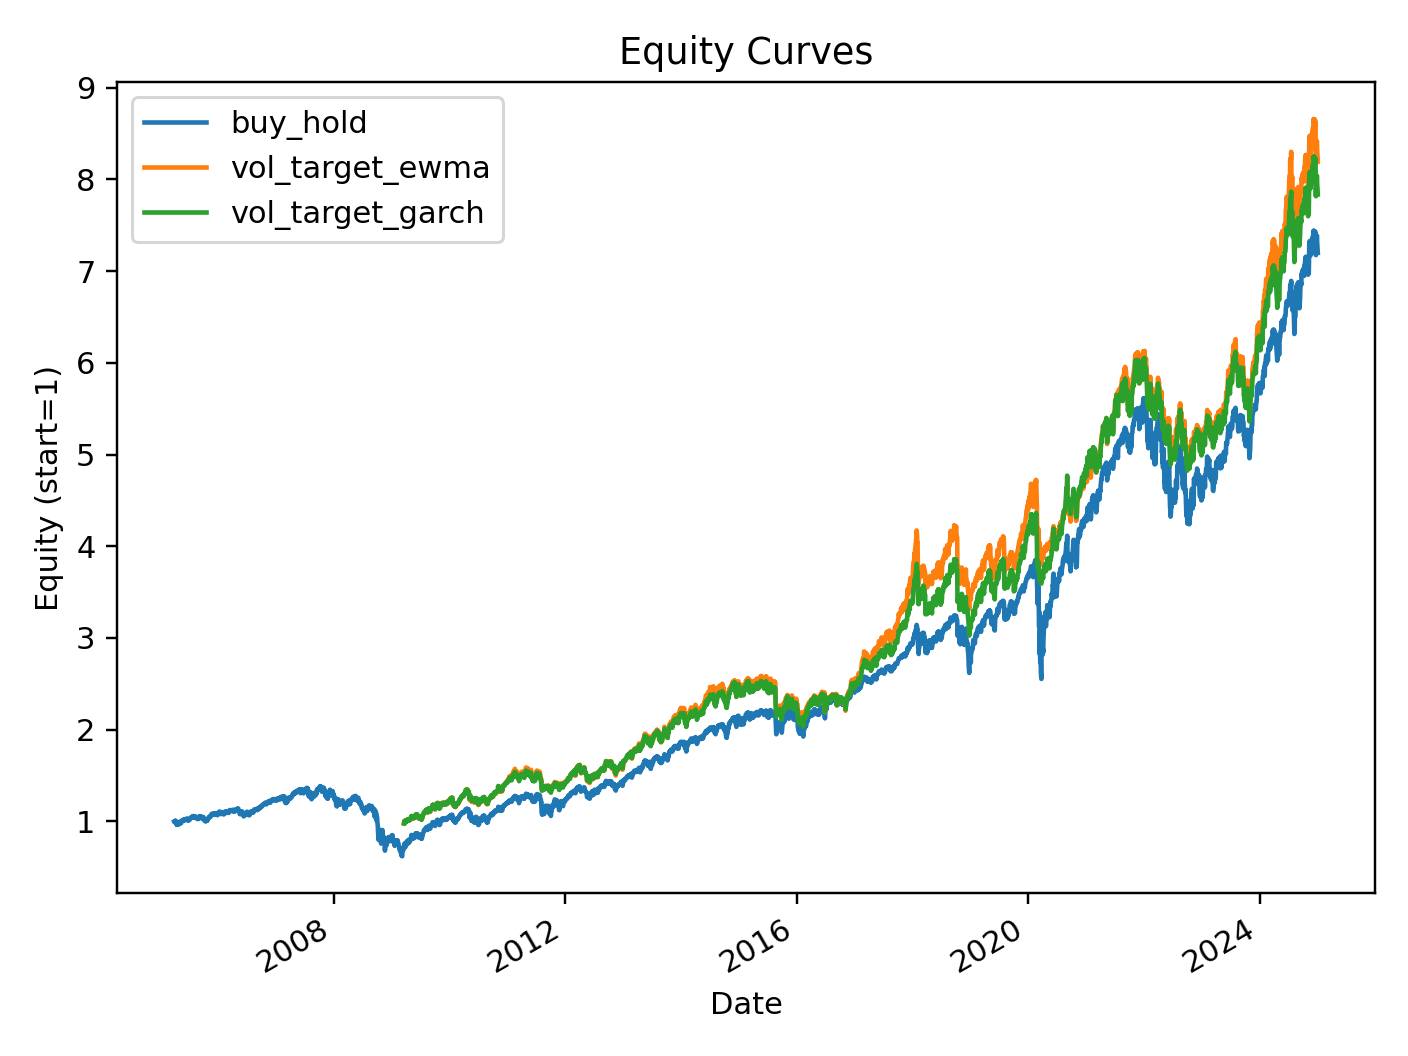
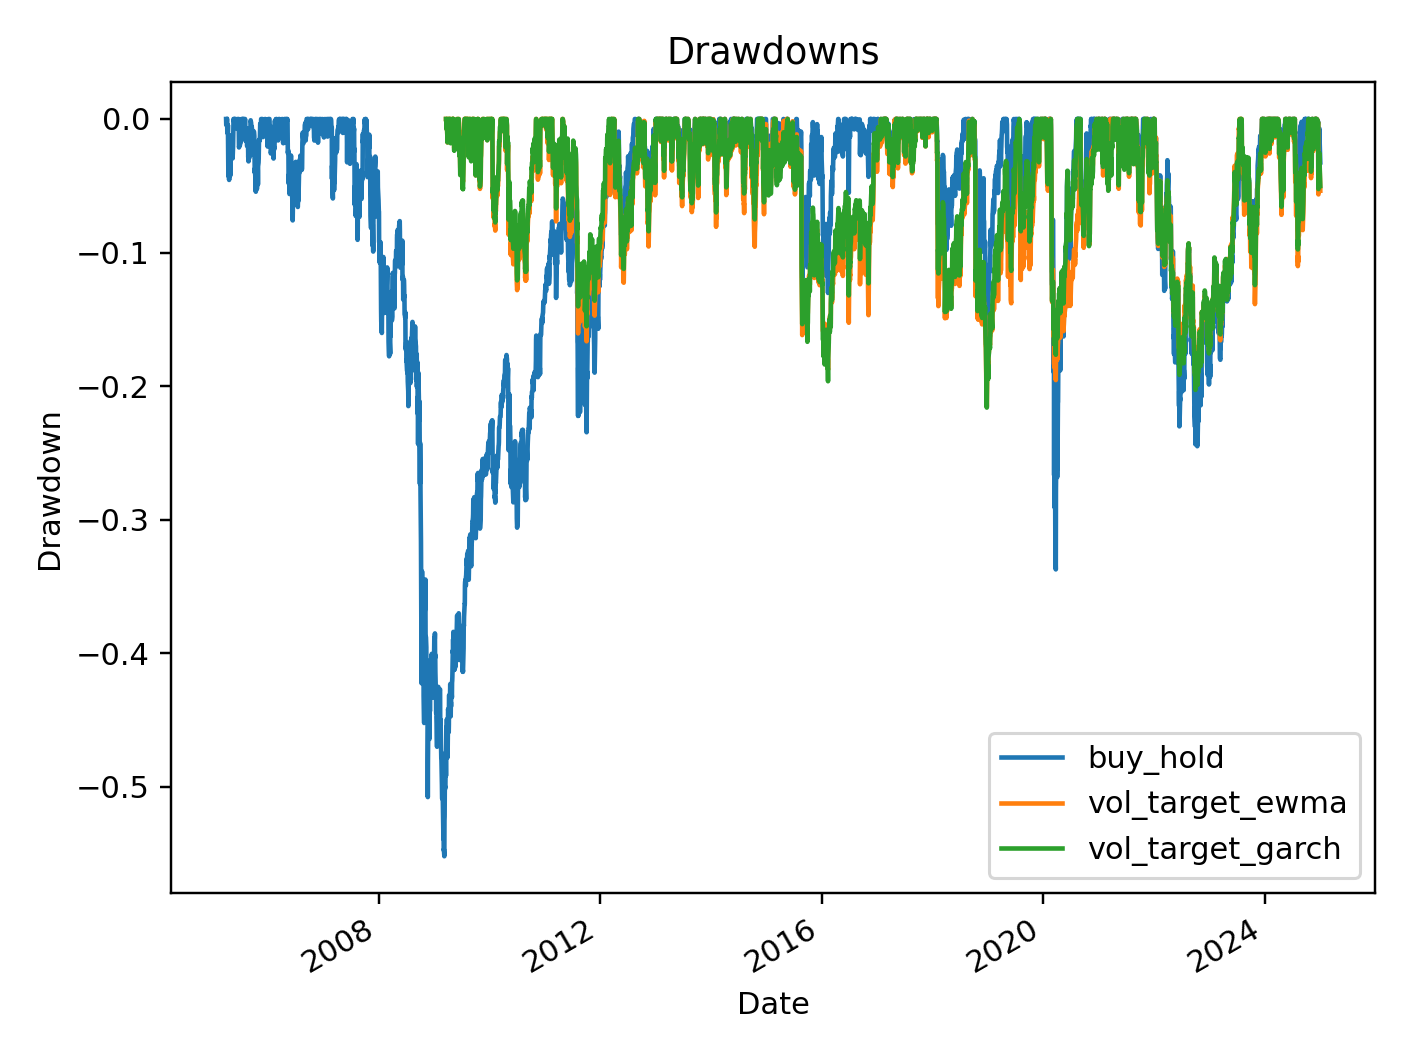

In [ ]:
from IPython.display import display, HTML
from pathlib import Path
import base64

root = Path.cwd()
if root.name == "notebooks":
    root = root.parent

fig_path = root / "reports" / "figures"

section_imgs = [
    "08_equity_curves.png",
    "09_drawdowns.png",
]

def img_to_base64(path):
    with open(path, "rb") as f:
        return base64.b64encode(f.read()).decode()

html = "<div style='display:grid; grid-template-columns: repeat(3, 1fr); gap:15px;'>"

for img in section_imgs:
    img_path = fig_path / img
    img_base64 = img_to_base64(img_path)
    html += f"""
        <div>
            <img src="data:image/png;base64,{img_base64}" 
                 style="width:100%; border-radius:6px;">
        </div>
    """

html += "</div>"

display(HTML(html))


---

## 7. Forecast Diagnostics

Beyond global loss metrics, we visually inspect forecast behavior.

We analyze for selected horizons ($h=1$ and $h=10$):

- Time-series comparison: forecast vs realized
- Scatter plot: forecast vs realized
- Error distribution

This allows us to detect:

- Systematic bias
- Under/over-reaction to shocks
- Horizon-dependent miscalibration
- Distributional asymmetry

Visual diagnostics often reveal patterns that metrics alone cannot detect.


In [23]:
from plots import (
    plot_forecast_vs_realized,
    plot_forecast_scatter,
    plot_error_distribution,
)

# Evaluate on h=1 and h=10 (clean + sufficient for a vitrine notebook)
for h in (1, 10):
    for model in ("roll20", "ewma", "garch"):
        plot_forecast_vs_realized(cfg, df, forecast_panel, model=model, h=h)
        plot_forecast_scatter(cfg, df, forecast_panel, model=model, h=h)
        plot_error_distribution(cfg, df, forecast_panel, model=model, h=h)




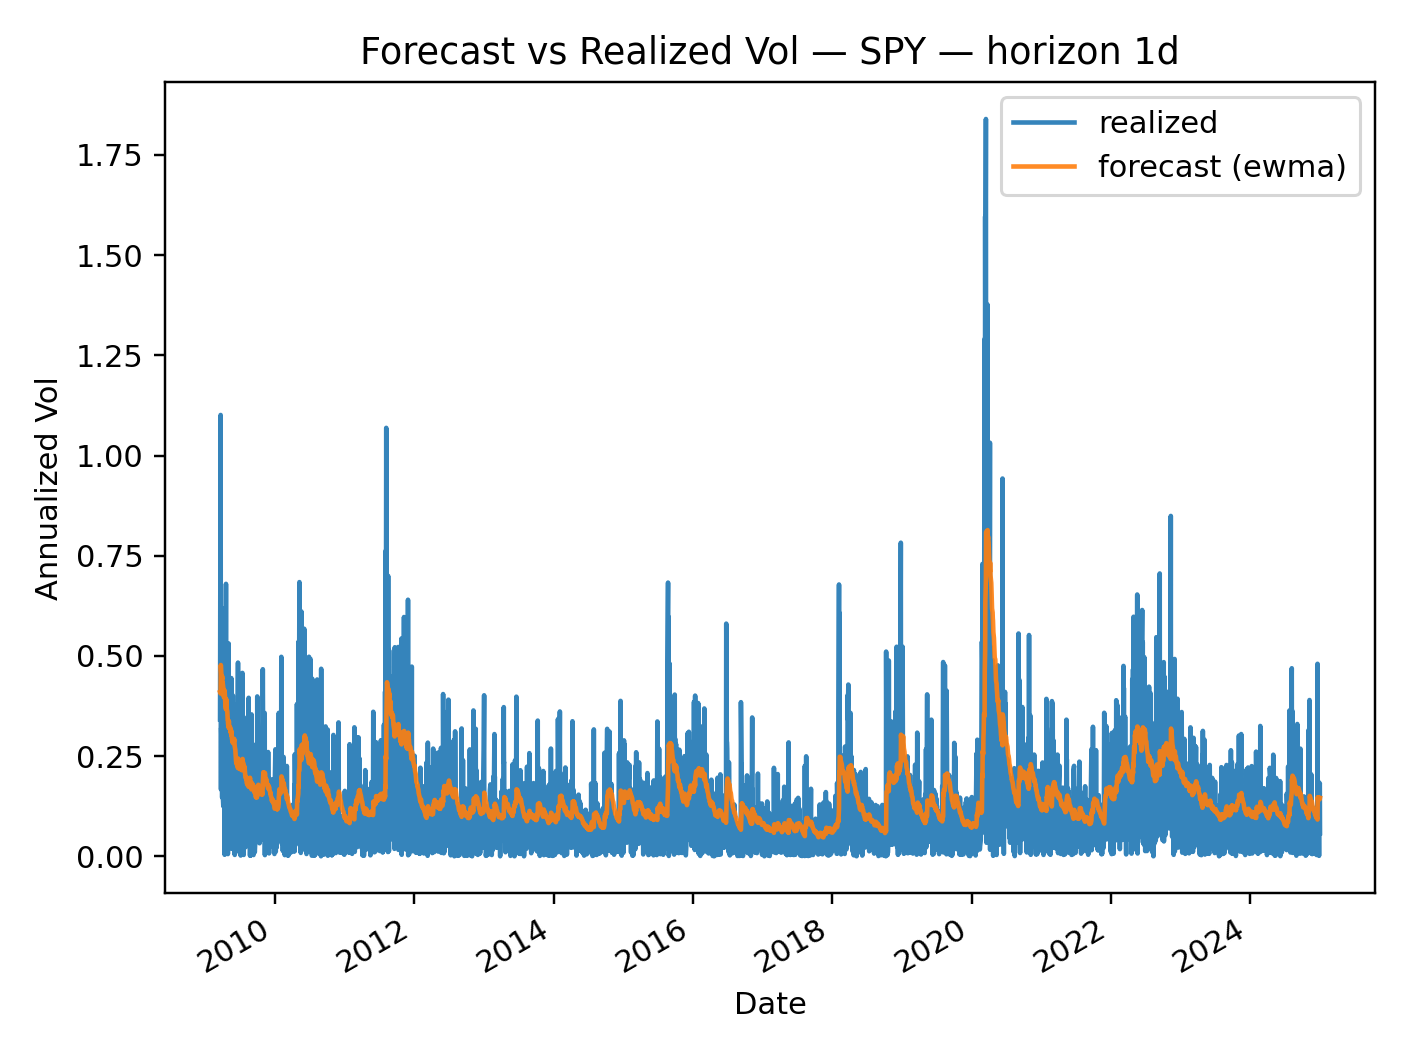
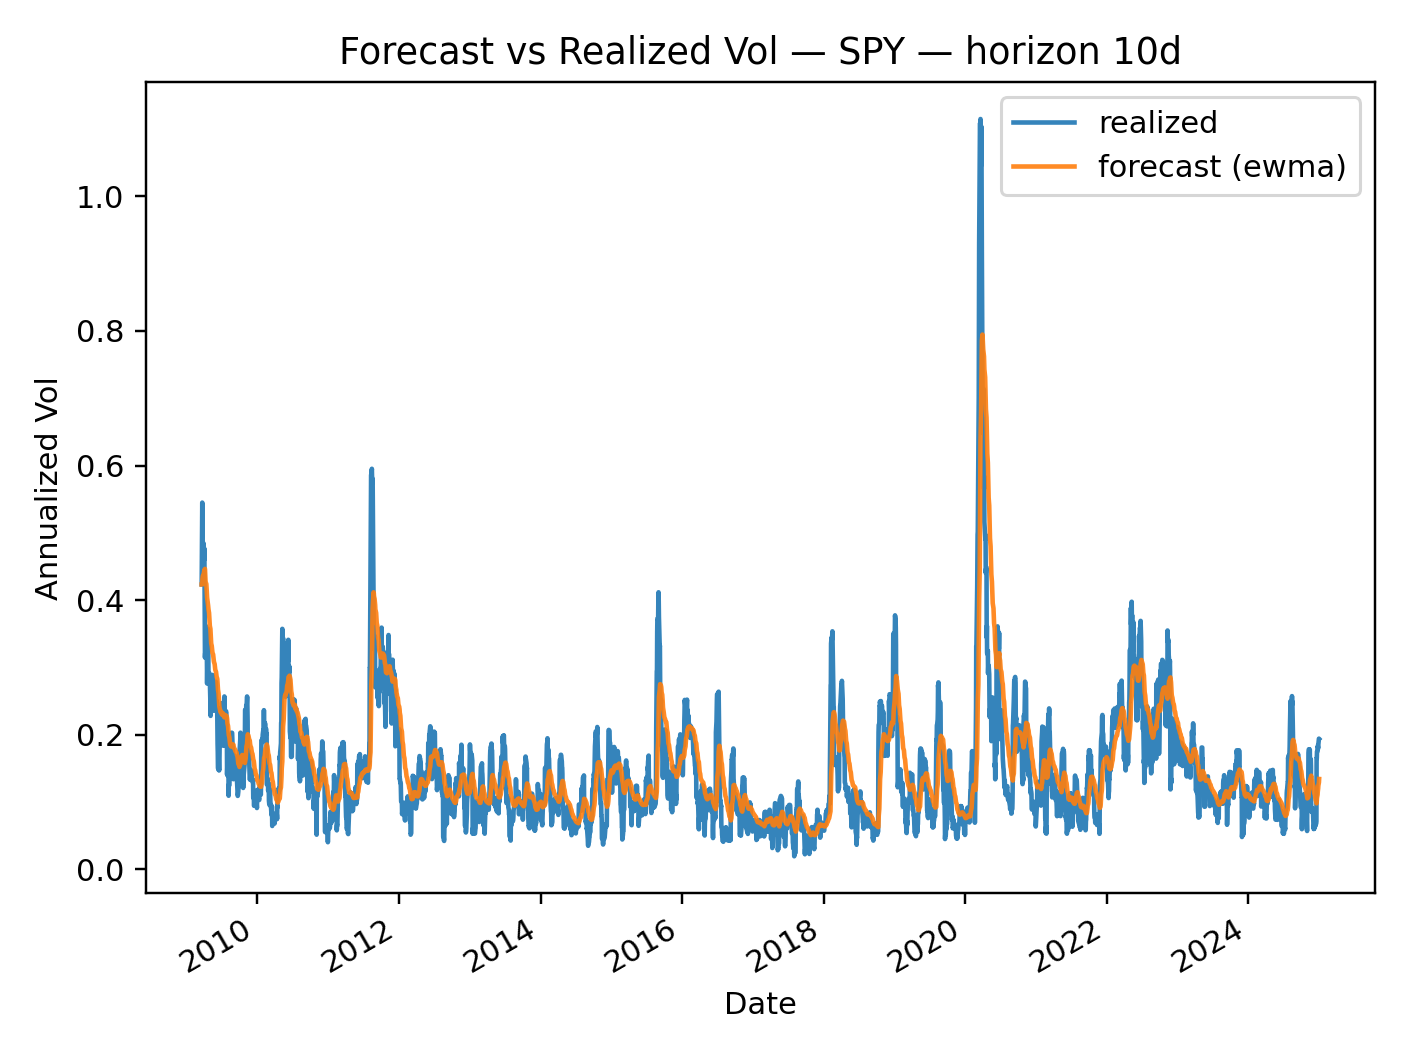
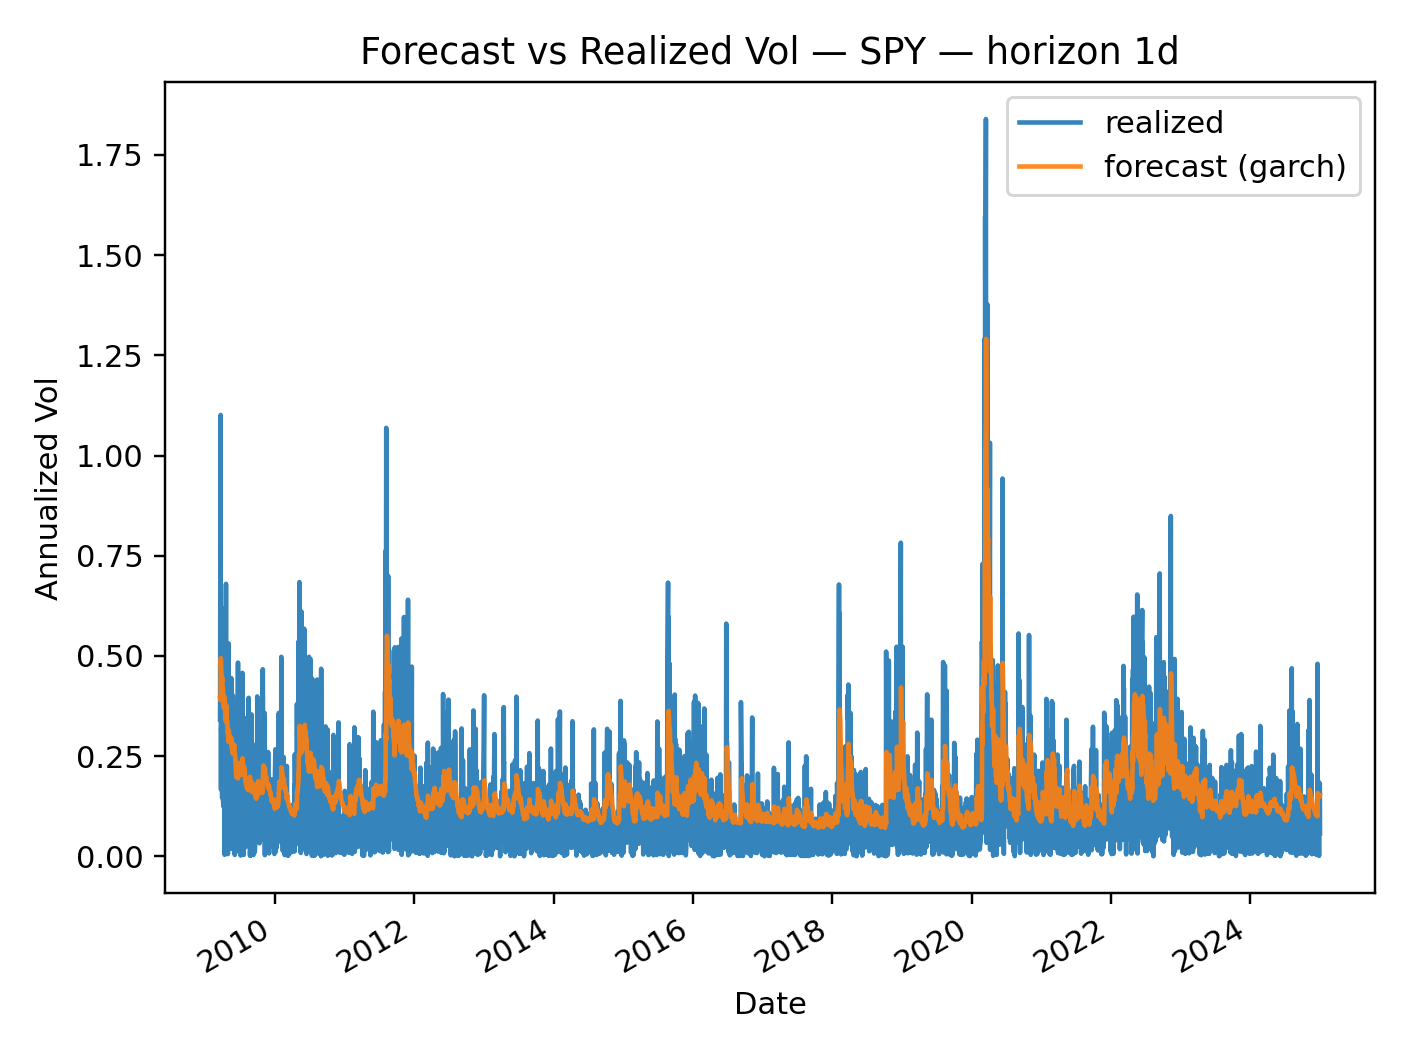
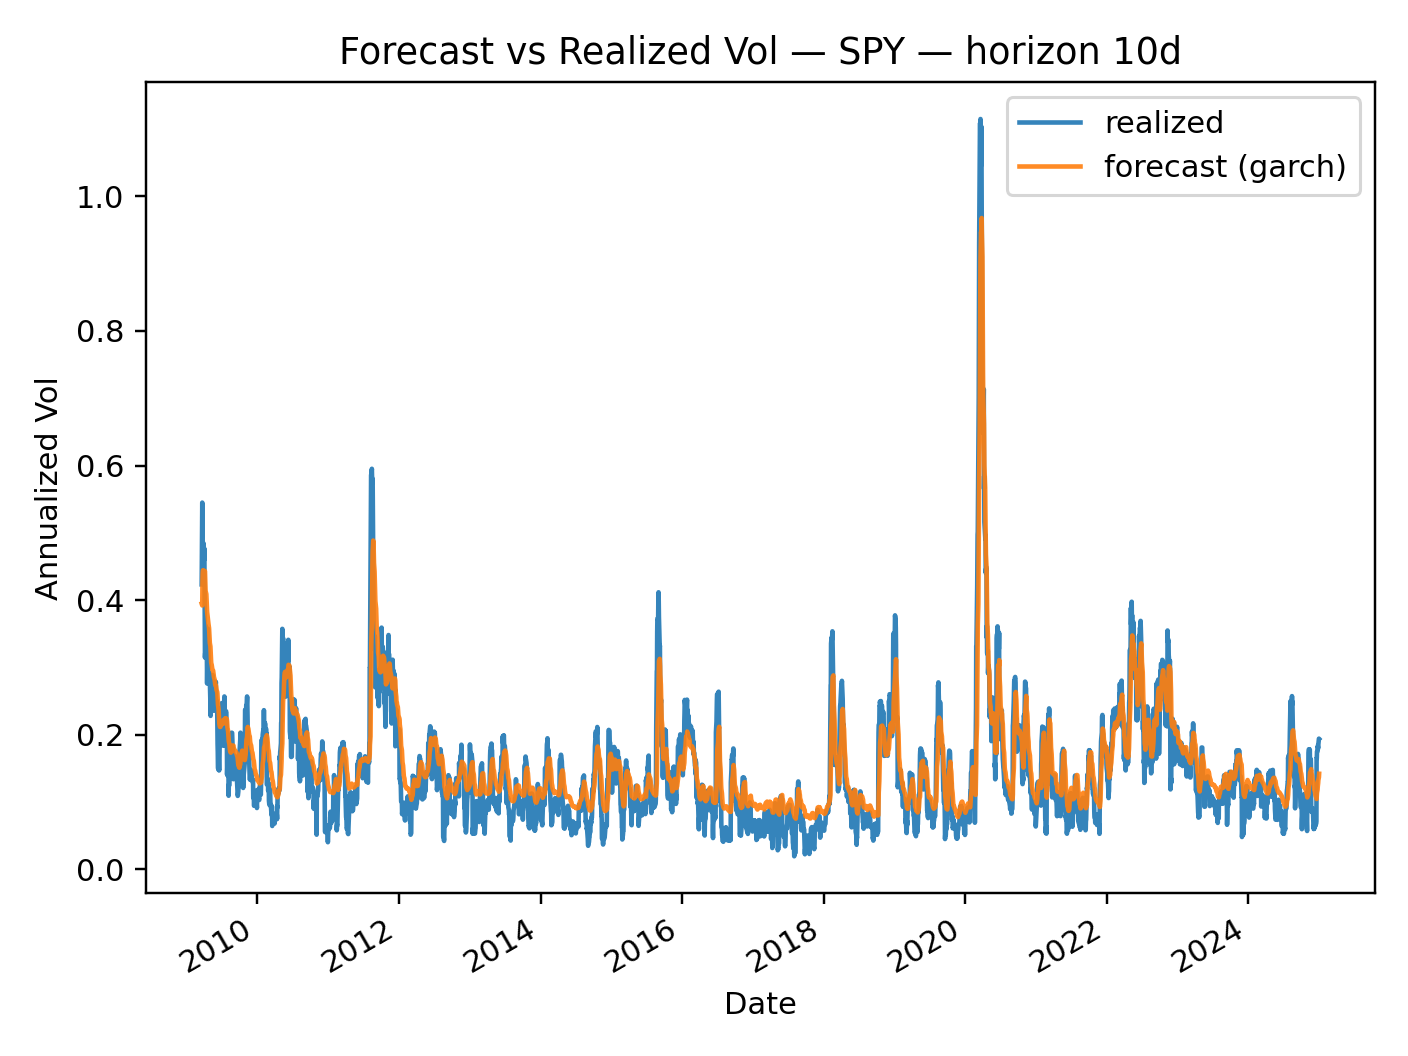
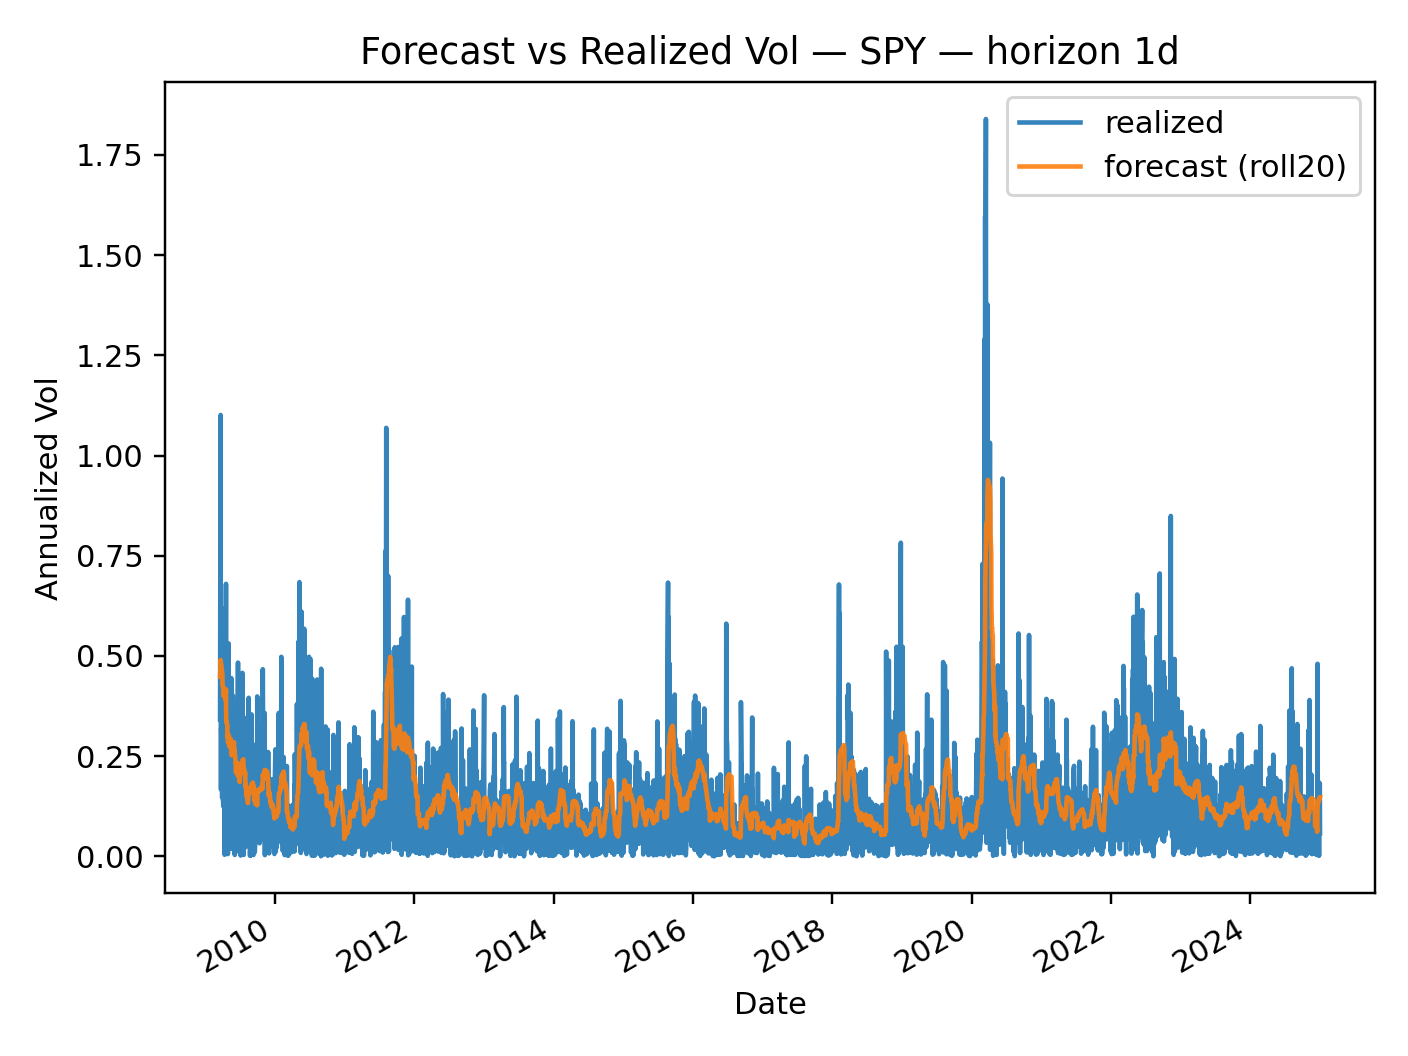
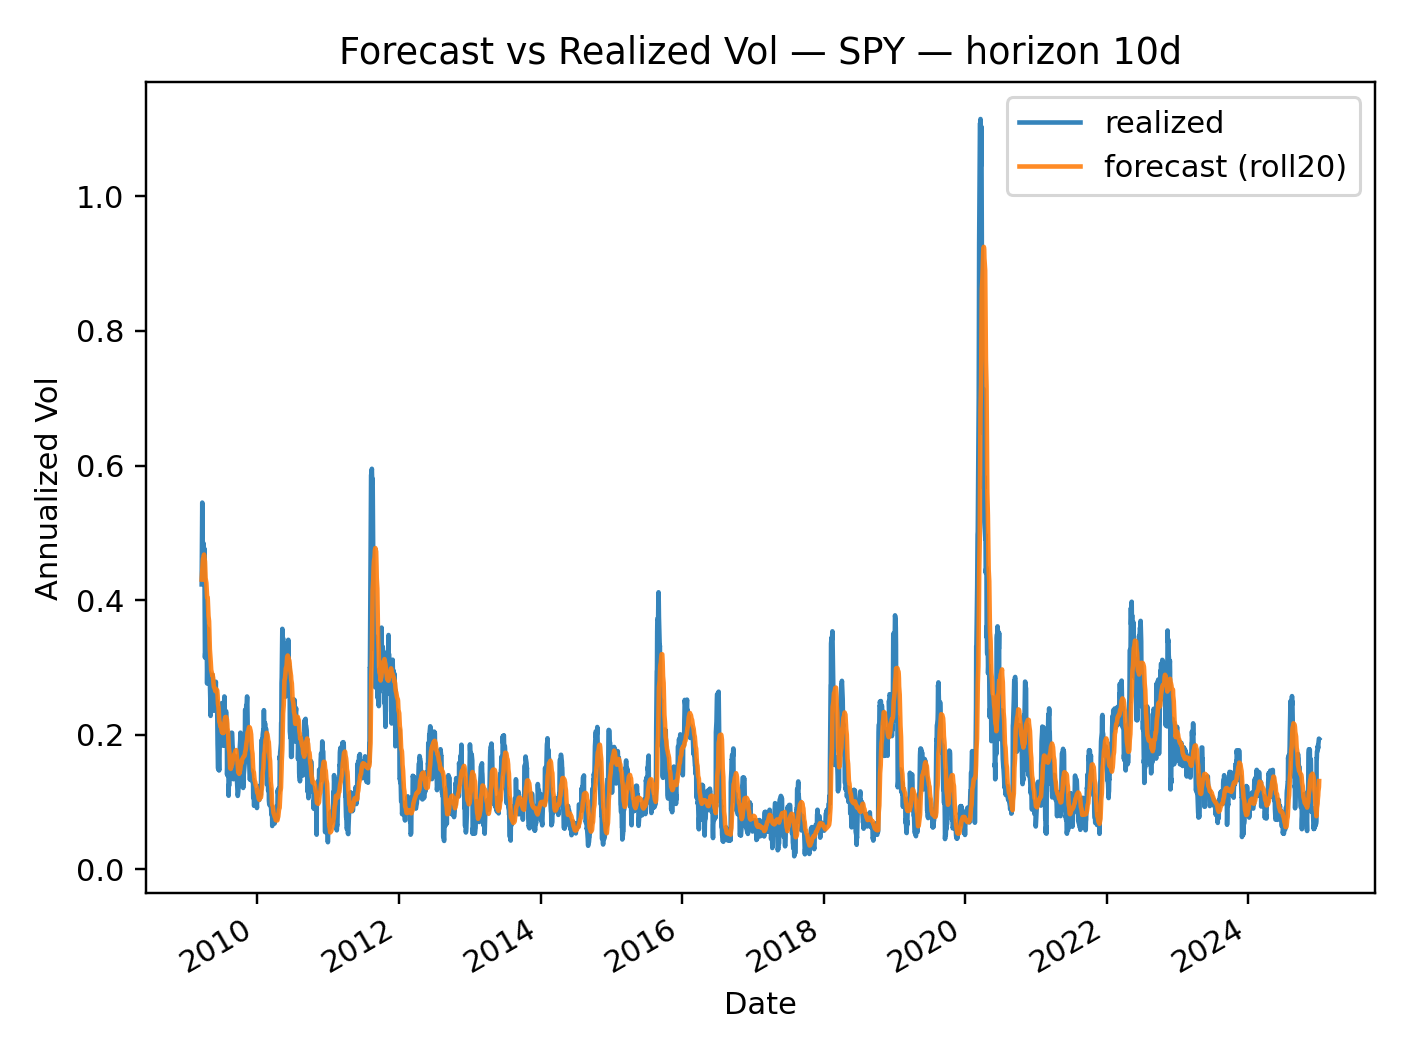
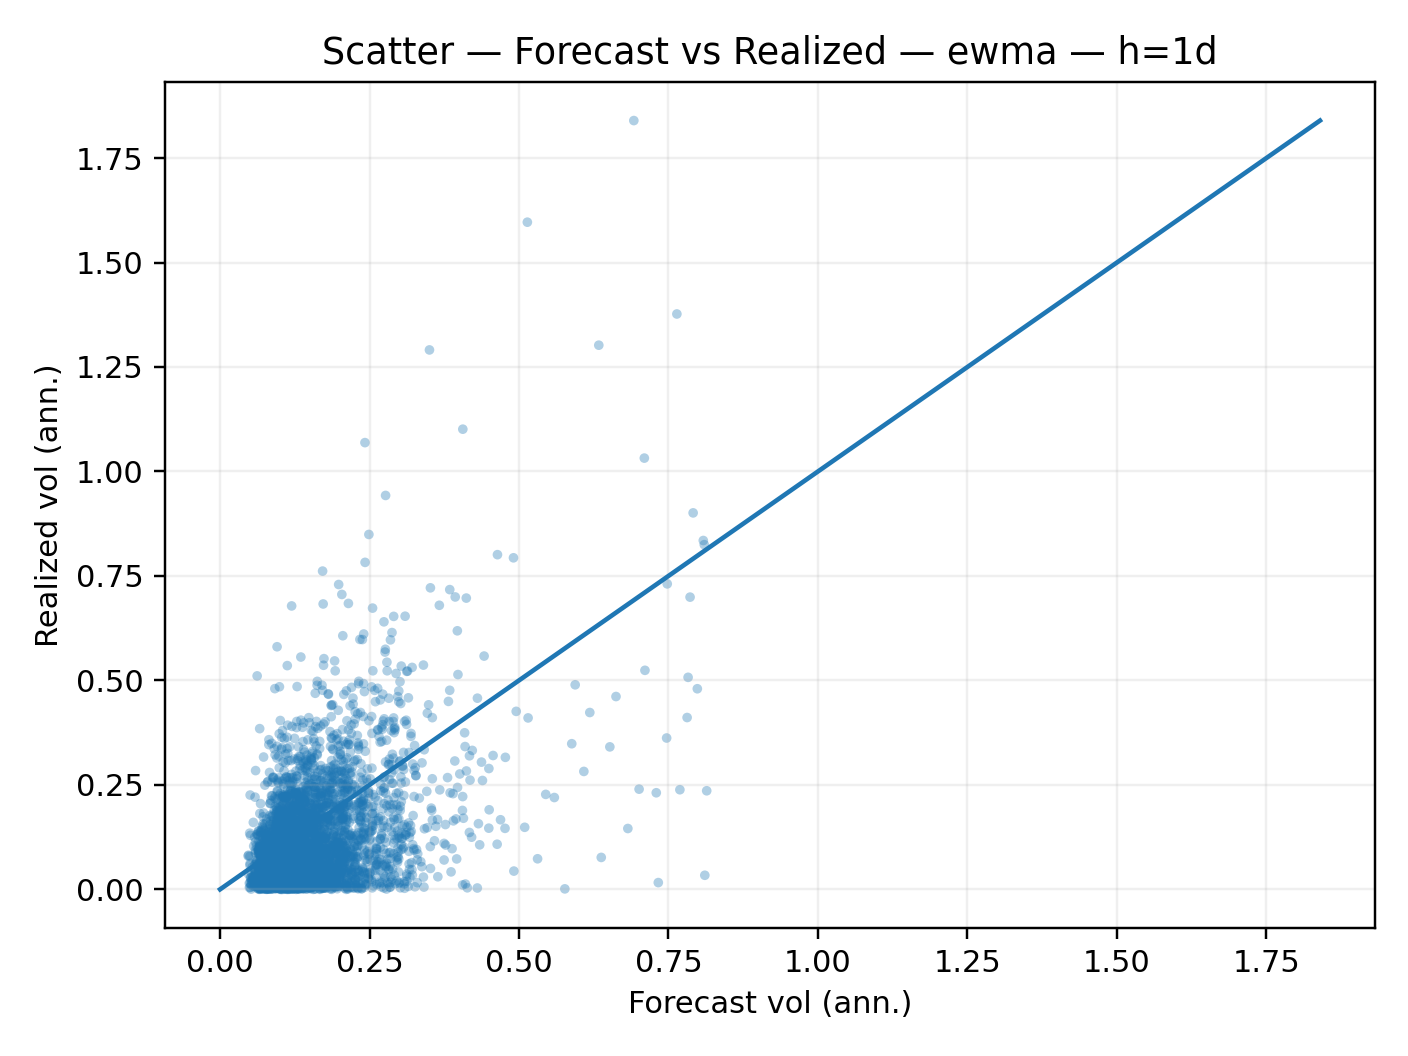
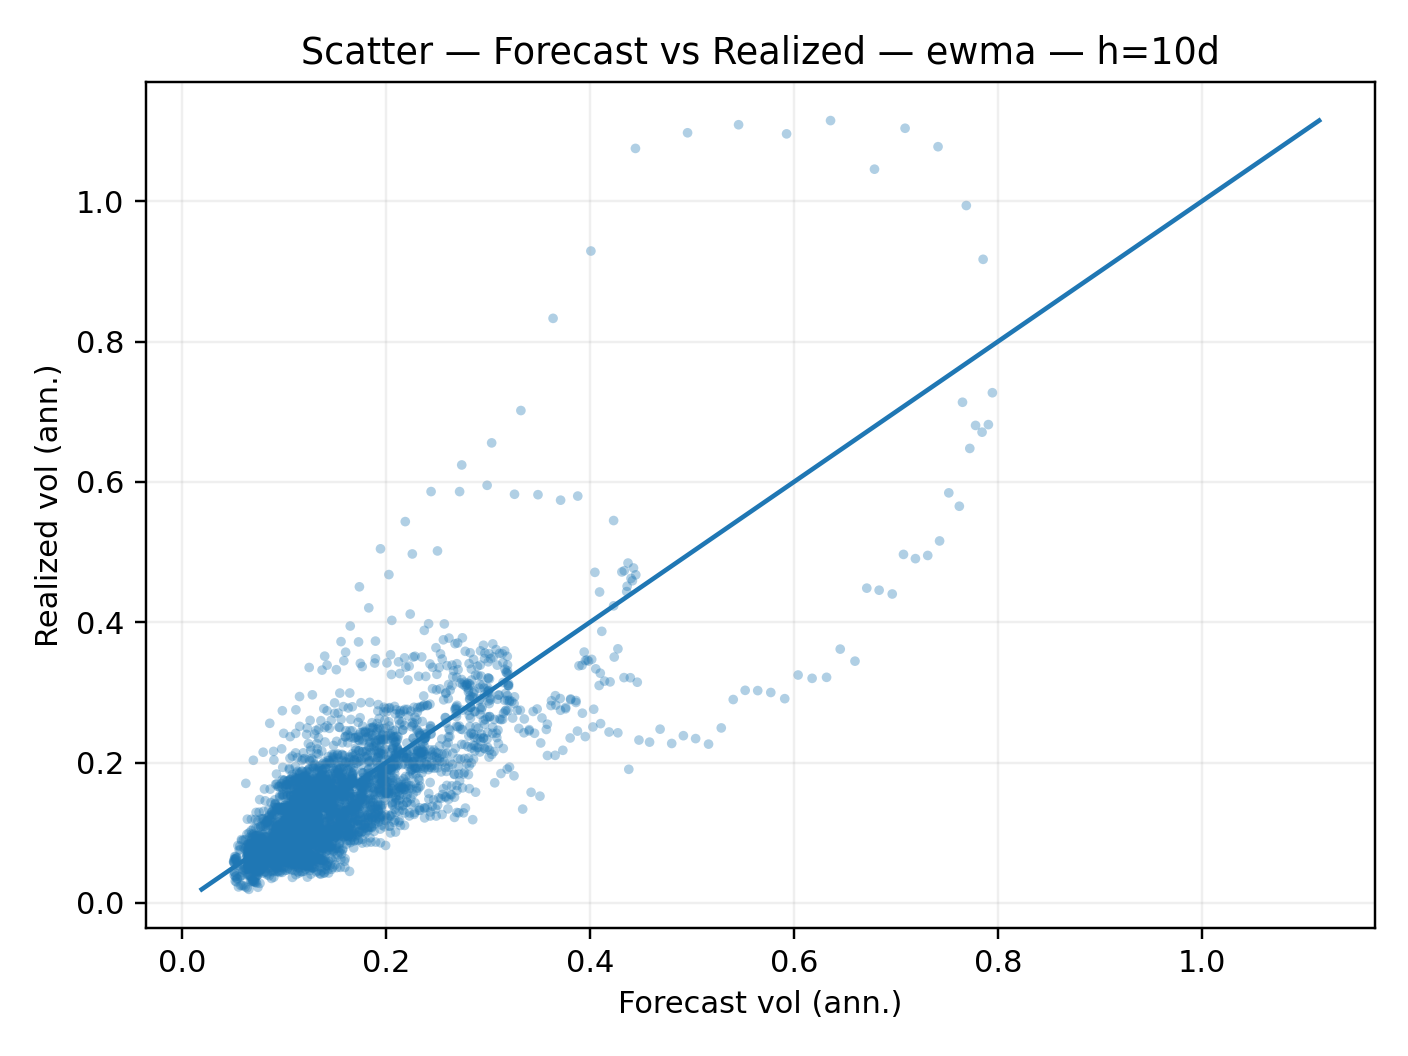
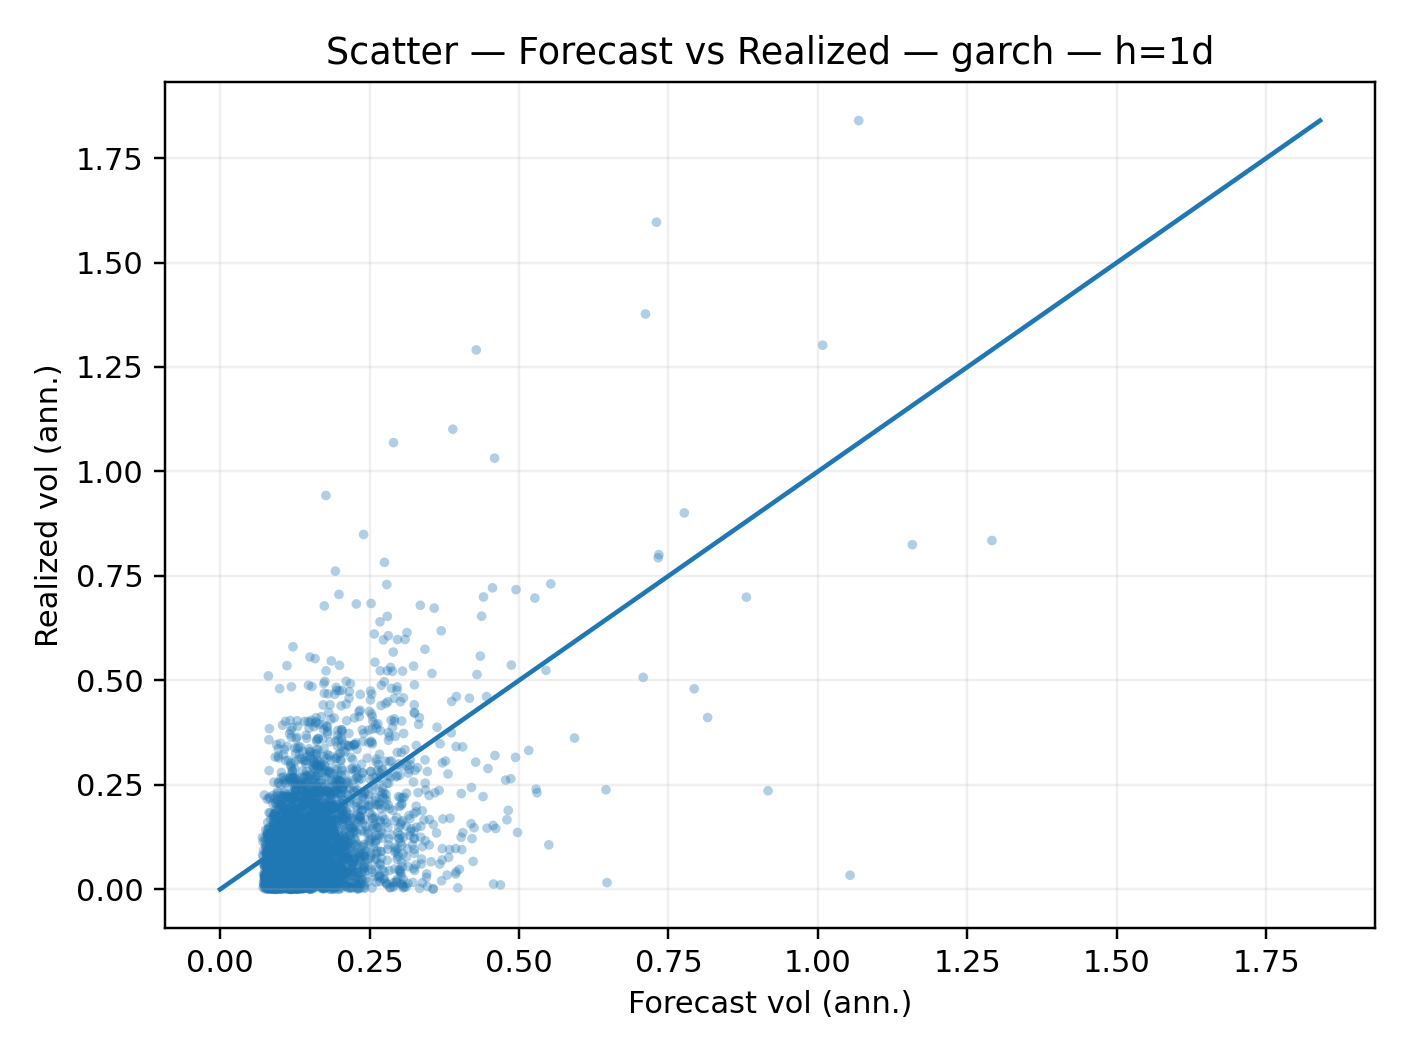
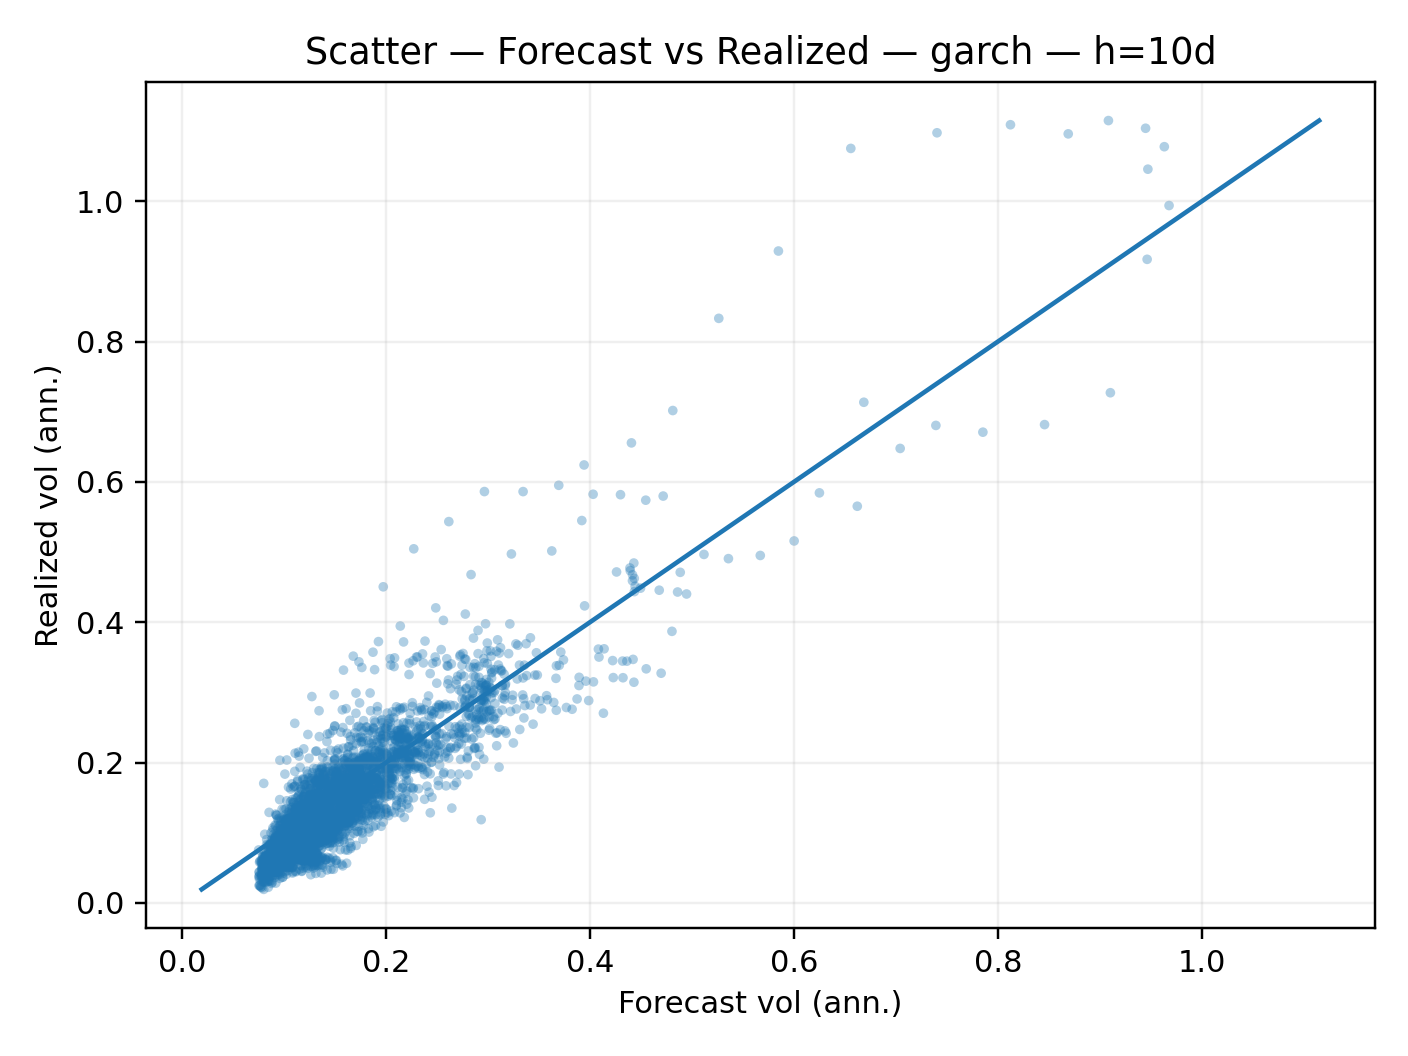
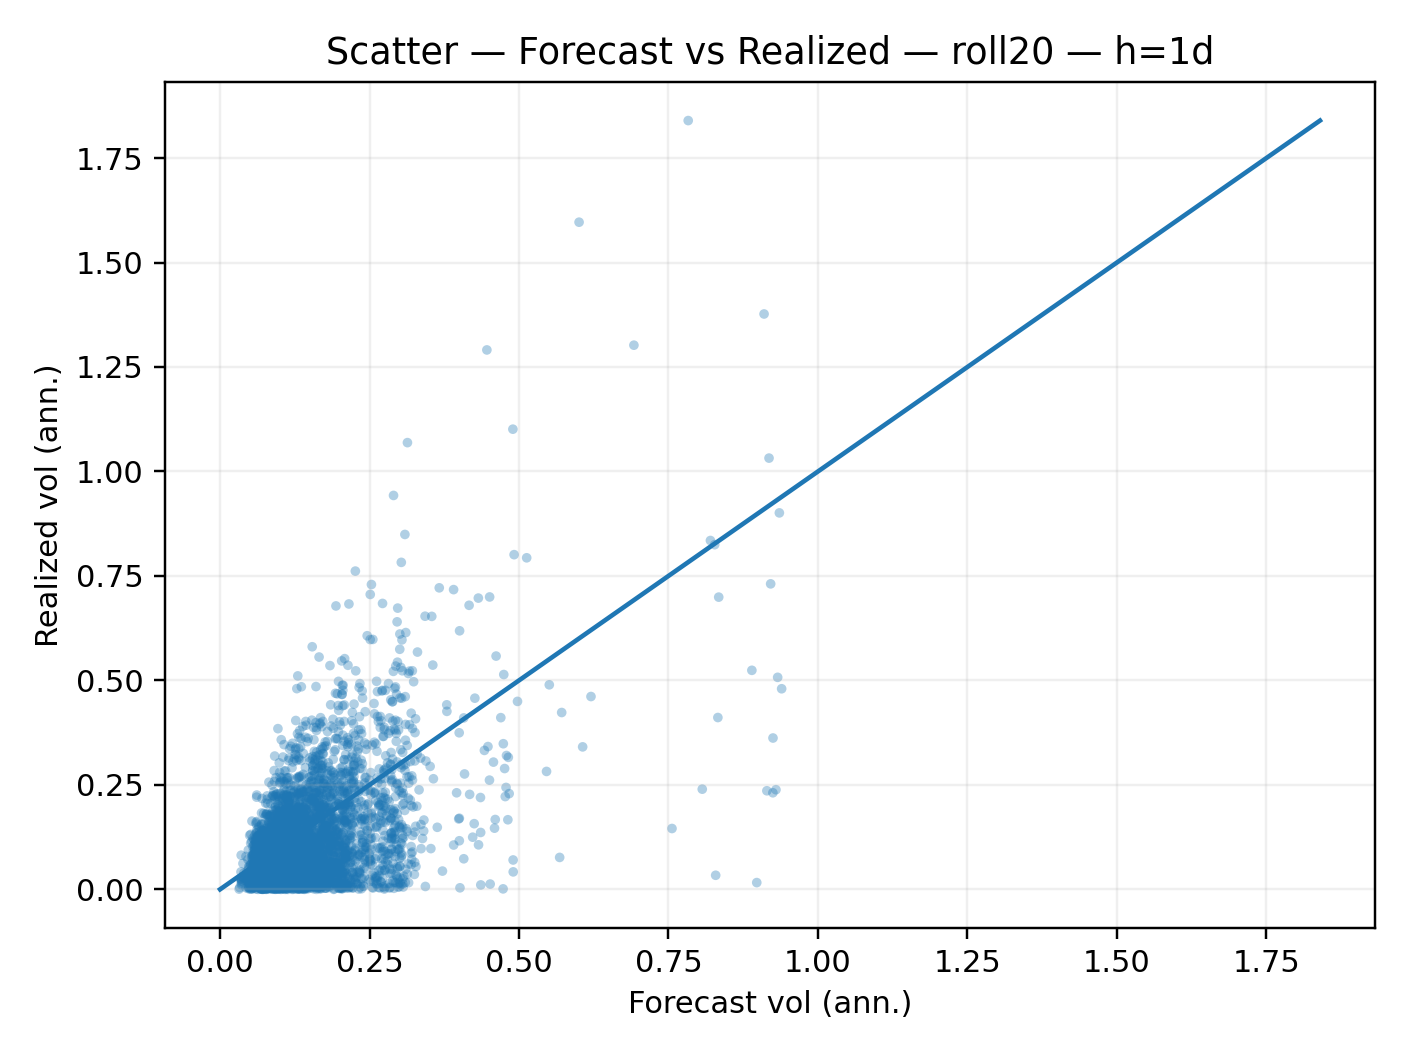
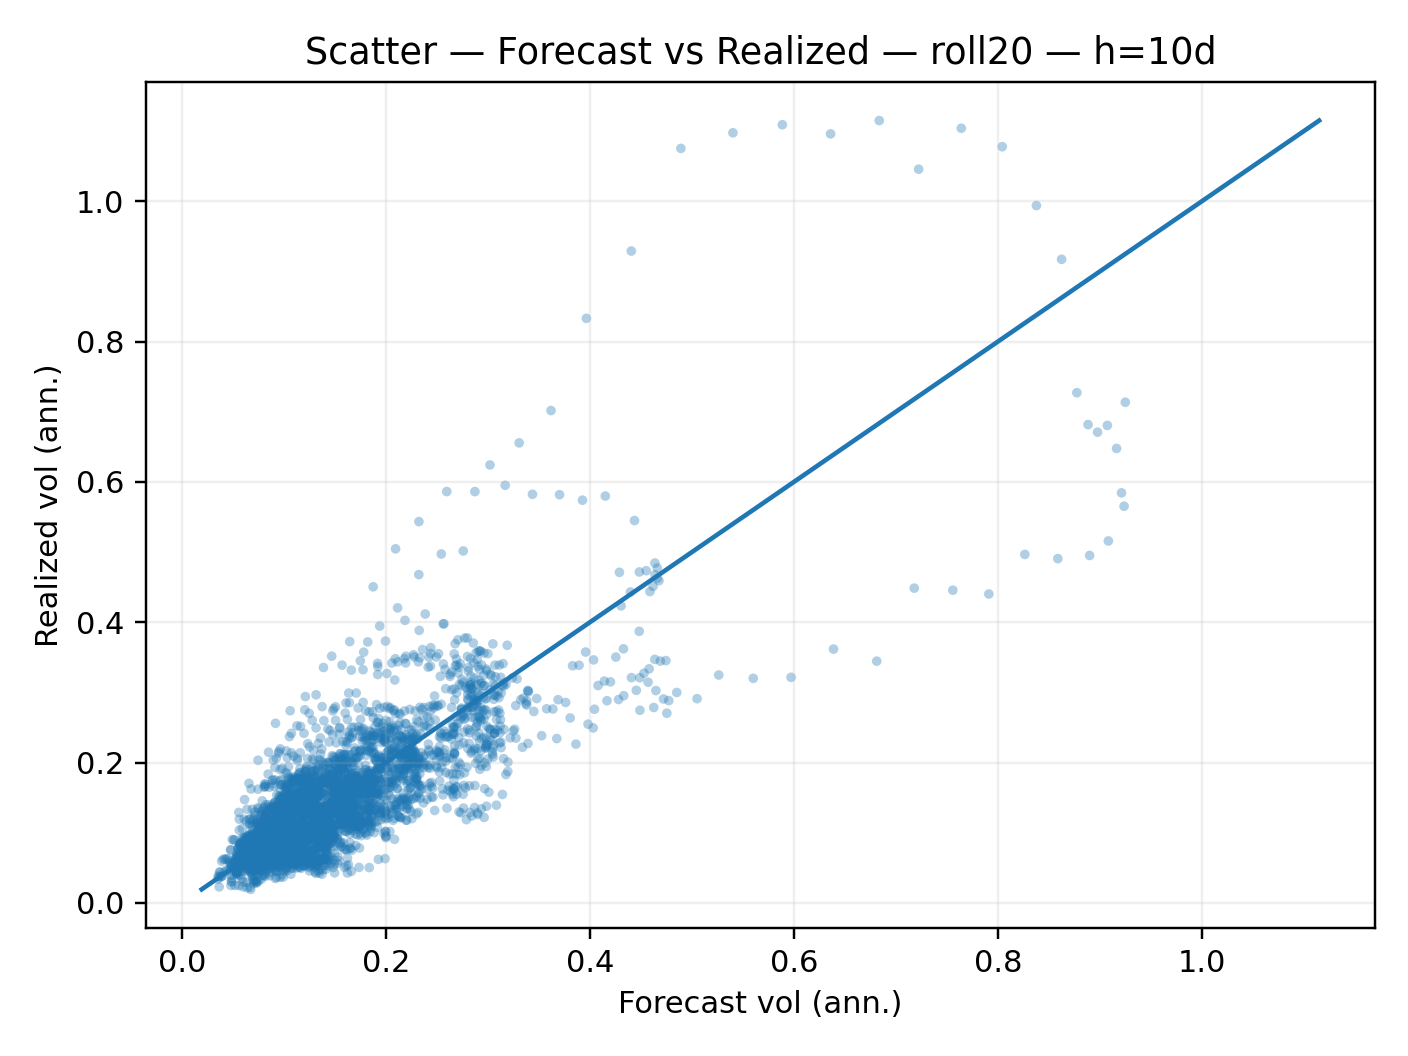
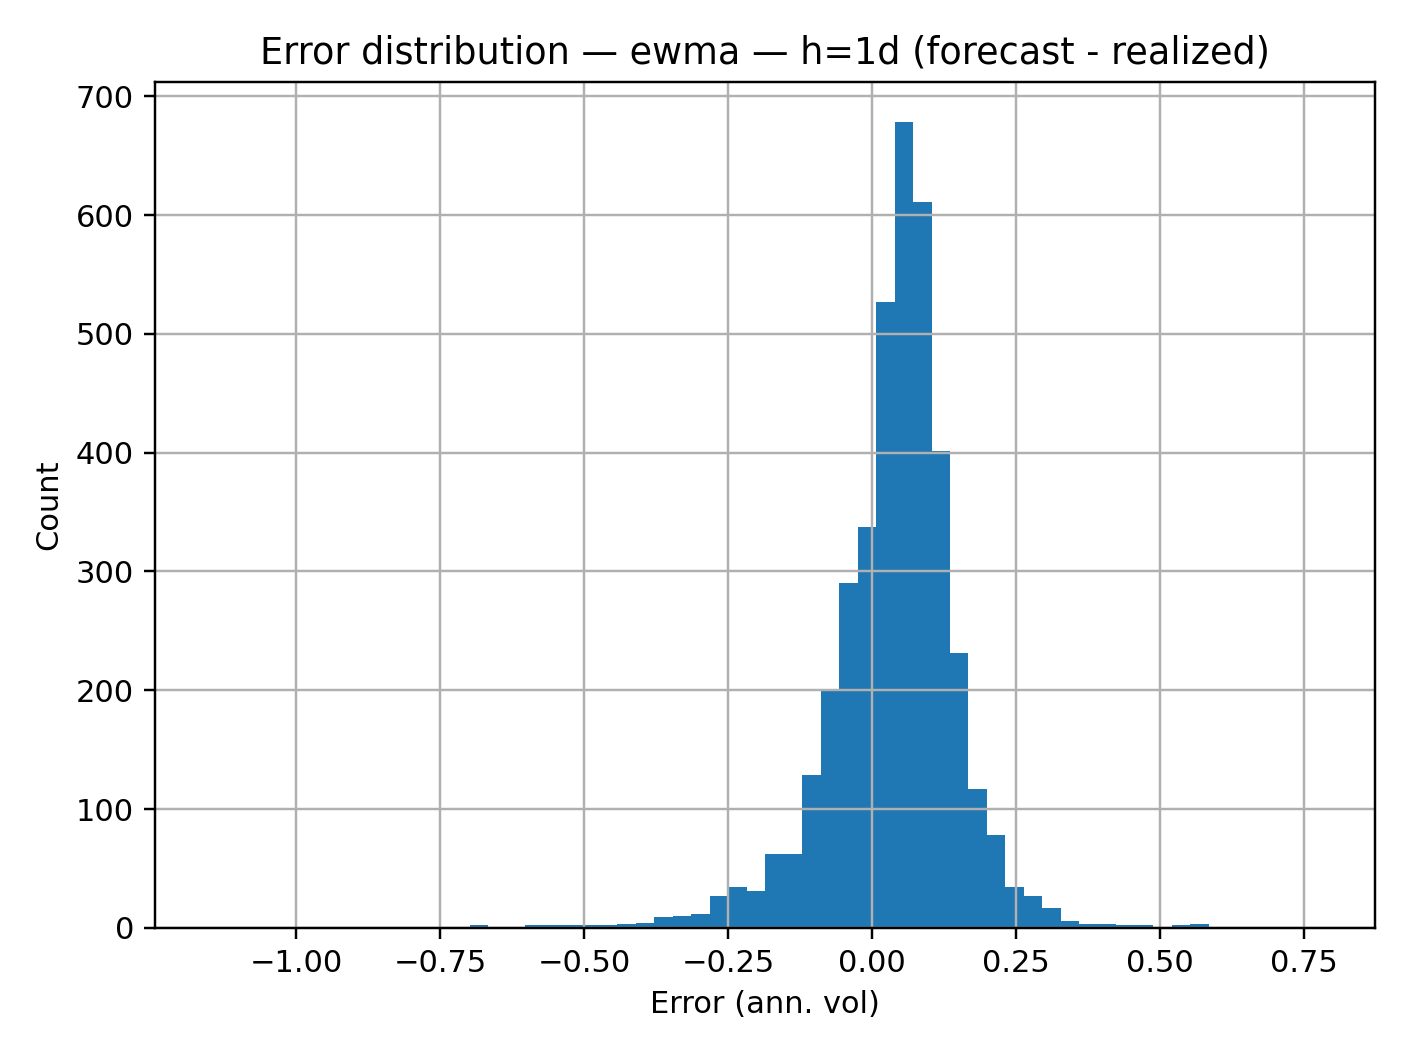
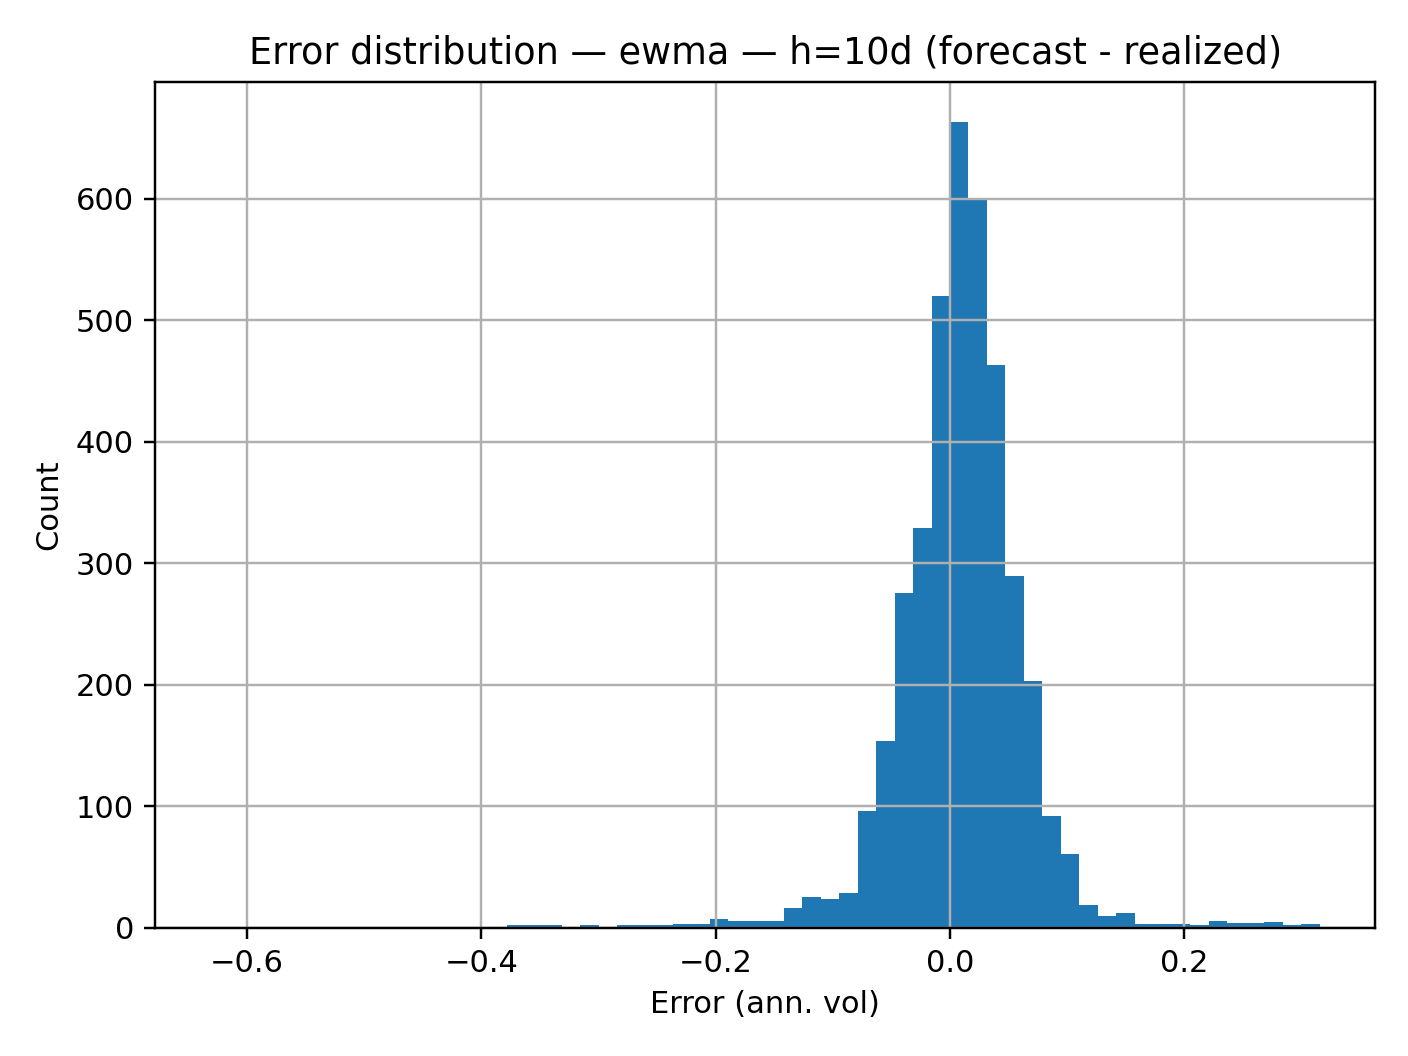
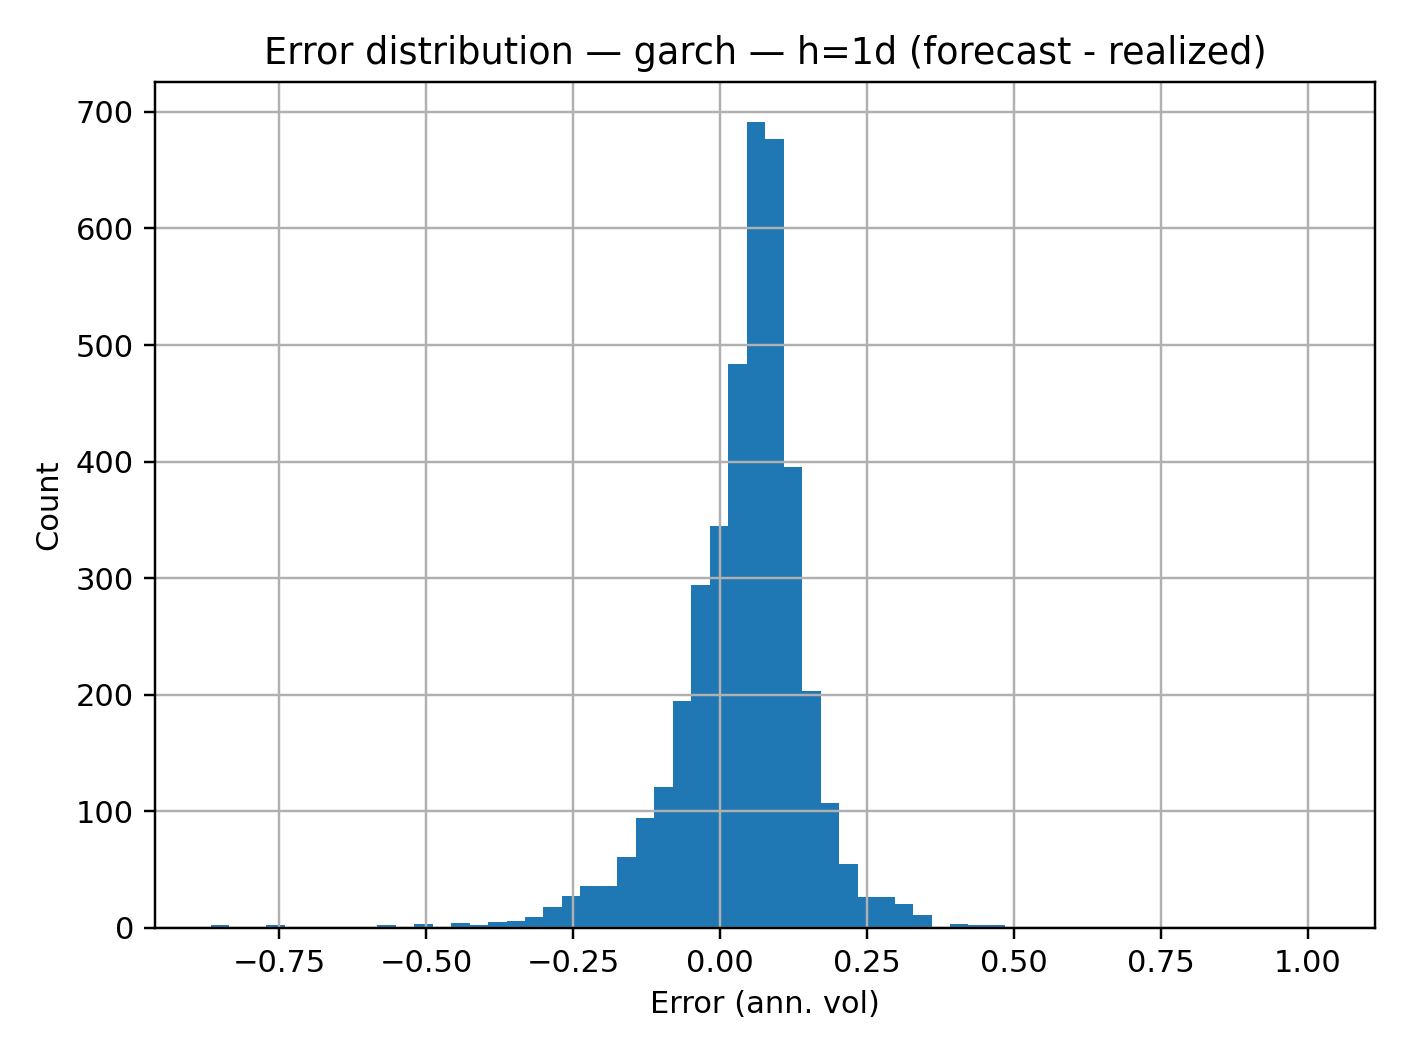
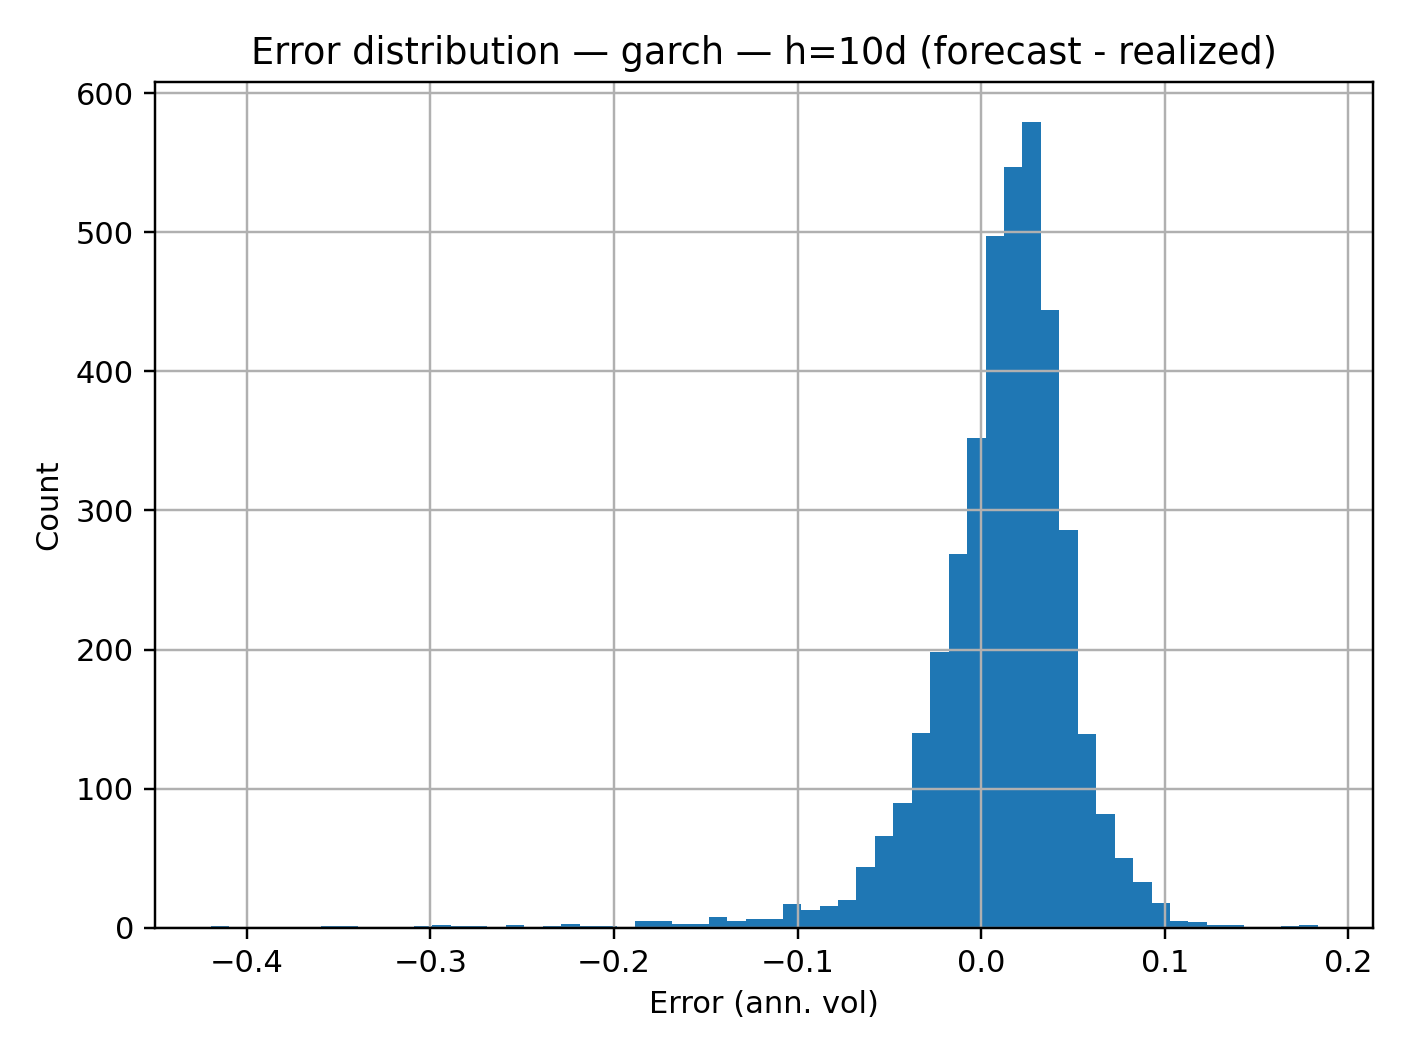
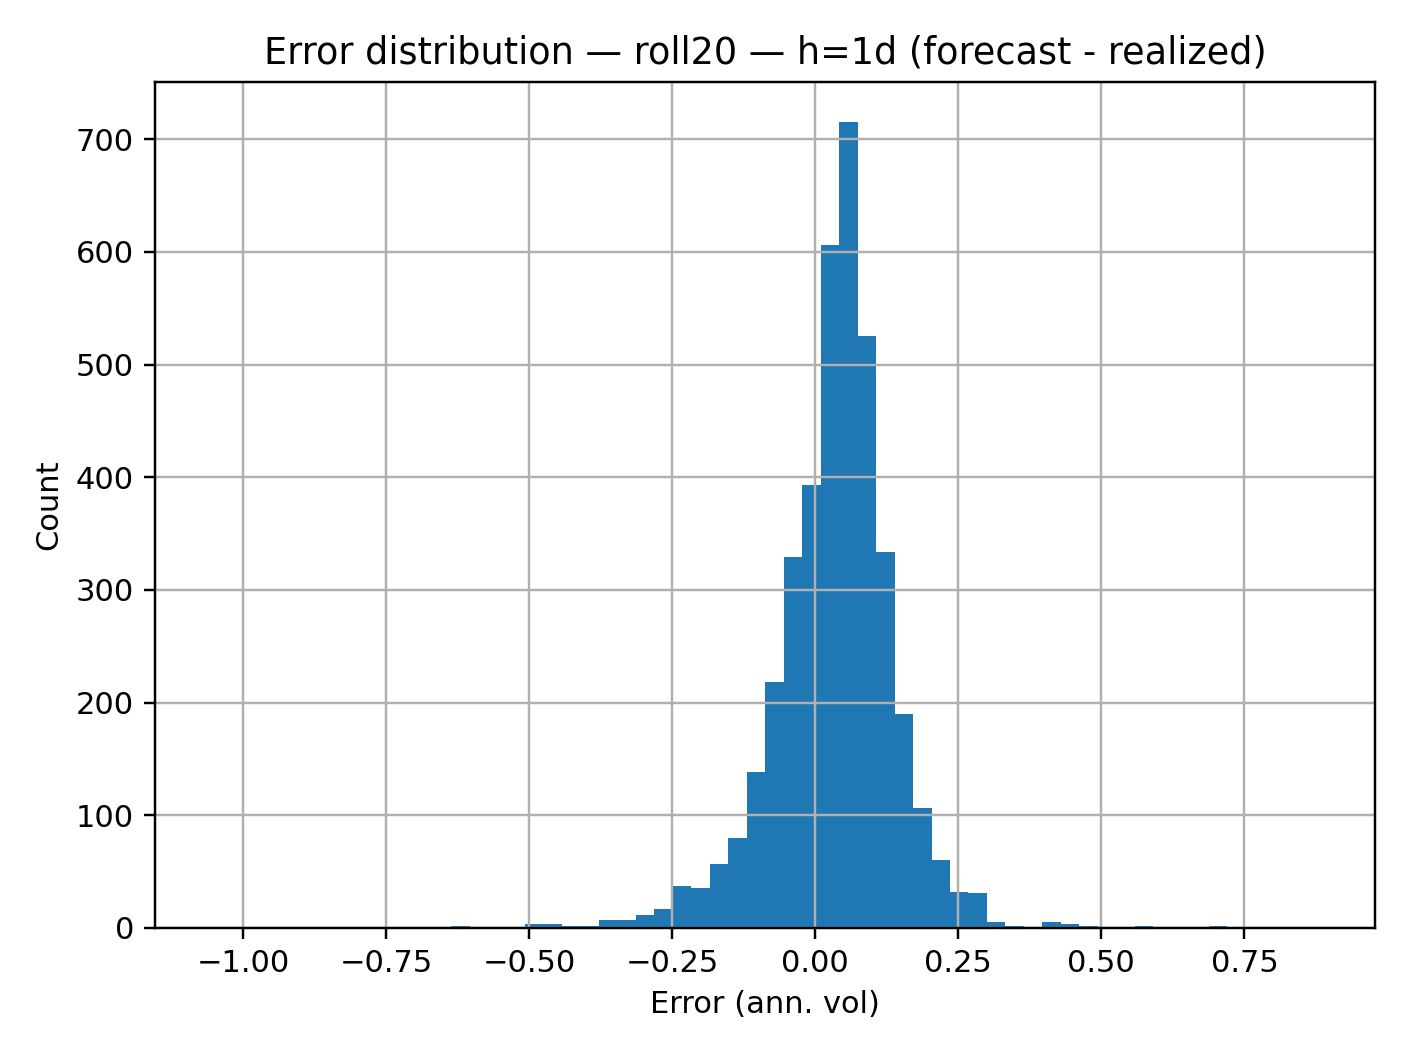
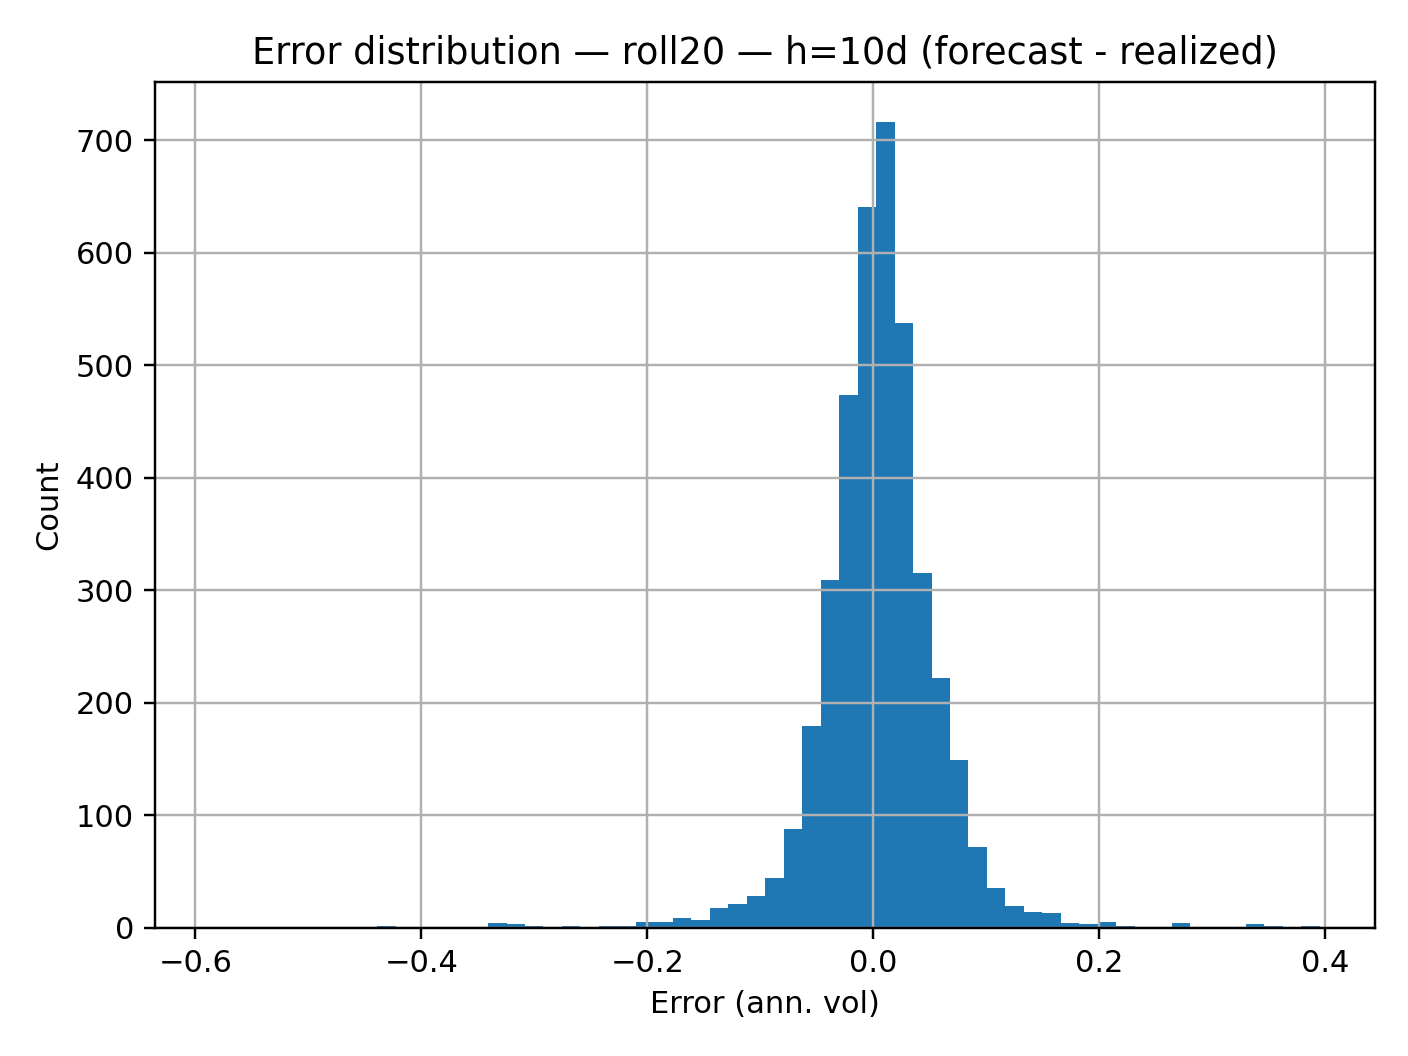

In [ ]:
from IPython.display import display, HTML
from pathlib import Path
import base64

root = Path.cwd()
if root.name == "notebooks":
    root = root.parent

fig_path = root / "reports" / "figures"

section_imgs = [
    "10_fcast_vs_real_ewma_h1.png",
    "10_fcast_vs_real_ewma_h10.png",
    "10_fcast_vs_real_garch_h1.png",
    "10_fcast_vs_real_garch_h10.png",
    "10_fcast_vs_real_roll20_h1.png",
    "10_fcast_vs_real_roll20_h10.png",
    "11_scatter_ewma_h1.png",
    "11_scatter_ewma_h10.png",
    "11_scatter_garch_h1.png",
    "11_scatter_garch_h10.png",
    "11_scatter_roll20_h1.png",
    "11_scatter_roll20_h10.png",
    "12_error_hist_ewma_h1.png",
    "12_error_hist_ewma_h10.png",
    "12_error_hist_garch_h1.png",
    "12_error_hist_garch_h10.png",
    "12_error_hist_roll20_h1.png",
    "12_error_hist_roll20_h10.png",
]

def img_to_base64(path):
    with open(path, "rb") as f:
        return base64.b64encode(f.read()).decode()

html = "<div style='display:grid; grid-template-columns: repeat(3, 1fr); gap:15px;'>"

for img in section_imgs:
    img_path = fig_path / img
    img_base64 = img_to_base64(img_path)
    html += f"""
        <div>
            <img src="data:image/png;base64,{img_base64}" 
                 style="width:100%; border-radius:6px;">
        </div>
    """

html += "</div>"

display(HTML(html))


---

## 8. Robustness Analysis

Forecast performance can be sensitive to parameter choices.

We perform a light robustness analysis by varying:

- EWMA persistence parameter ($\lambda$)
- GARCH refit frequency

We compare:

- Baseline configuration
- Higher persistence EWMA ($\lambda = 0.97$)
- Less frequent GARCH refitting

The objective is to verify that our conclusions are not driven by a specific calibration.


In [24]:
from models import build_forecast_panel
from metrics import evaluate_forecasts

# --- Small robustness grid (light)
settings = [
    {"name": "base", "ewma_lambda": cfg.ewma_lambda, "refit_every": cfg.refit_every},
    {"name": "ewma_lambda_0.97", "ewma_lambda": 0.97, "refit_every": cfg.refit_every},
    {"name": "garch_refit_5", "ewma_lambda": cfg.ewma_lambda, "refit_every": 5},
]

rows = []

for s in settings:
    # create a modified config (dataclass frozen -> use replace pattern)
    from dataclasses import replace
    cfg_ = replace(cfg, ewma_lambda=s["ewma_lambda"], refit_every=s["refit_every"])

    fp = build_forecast_panel(df, cfg_, include_baselines=True)
    mdf = evaluate_forecasts(df, fp, cfg_)

    # best model per horizon by QLIKE
    best_ = (
        mdf.sort_values(["horizon_days", "QLIKE"])
           .groupby("horizon_days", as_index=False)
           .first()
    )

    best_["setting"] = s["name"]
    rows.append(best_[["setting", "horizon_days", "model", "QLIKE", "RMSE", "MAE", "n_obs"]])

robust_best = pd.concat(rows, axis=0).reset_index(drop=True)

print("Robustness (best model per horizon):")
robust_best


Robustness (best model per horizon):


setting  horizon_days   model     QLIKE      RMSE       MAE  n_obs
0              base             1  roll20 -3.019828  0.117535  0.085833   3973
1              base             5   garch -3.010602  0.056796  0.041230   3973
2              base            10   garch -2.999493  0.042553  0.030895   3973
3  ewma_lambda_0.97             1  roll20 -3.019828  0.117535  0.085833   3973
4  ewma_lambda_0.97             5   garch -3.010602  0.056796  0.041230   3973
5  ewma_lambda_0.97            10   garch -2.999493  0.042553  0.030895   3973
6     garch_refit_5             1  roll20 -3.019828  0.117535  0.085833   3973
7     garch_refit_5             5  roll20 -2.952155  0.069808  0.046652   3973
8     garch_refit_5            10  roll20 -2.941831  0.058300  0.037575   3973

---

## 9. Conclusion

This project implemented a complete volatility forecasting pipeline:

- Clean data construction
- Multi-horizon realized volatility targets
- Rolling, EWMA and GARCH forecasting models
- Statistical evaluation (MAE, MSE, QLIKE)
- Economic evaluation via volatility targeting
- Interactive 3D volatility surfaces
- Robustness analysis

---

### Main Insights

1. Volatility exhibits strong clustering and persistence.
2. EWMA and GARCH outperform simple rolling volatility statistically.
3. Multi-horizon analysis reveals term-structure dynamics.
4. Improved statistical forecasts often translate into improved Sharpe ratios under volatility targeting.
5. Robustness tests confirm that conclusions are stable across reasonable parameter variations.

---

### Key Takeaway

Better volatility modeling is not only a statistical exercise.

It directly impacts:

- Risk management
- Capital allocation
- Portfolio performance
- Drawdown control

Volatility forecasting is therefore both a statistical and economic problem.

---

### Possible Extensions

- Alternative distributions (Student-t GARCH)
- HAR-RV model
- Implied volatility integration
- Regime-switching models
- Transaction costs in backtest
- Multi-asset extension
